Print file contents and attributes:
h5dump -n 1 TEOB_dataI.hdf5
gsiscp vulcan2.aei.mpg.de:/work/mpuer/projects/gpsurrogate/test_40Hz_1D/TEOB_dataI.hdf5 .

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)

import constants
imp.reload(constants)
from constants import *

In [25]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

In [84]:
# def condition_eob_training_set_raw(
#     hlist, paramslist, h_filename, dh_filename,
#     delta_t, 
#     winon_i, winon_f, 
#     n_ext,
#     trunc_i, trunc_f, npoints=10000,
#     win='planck', plots=False, 
#     mtot=2.0, distance=1.0):
#     """Make a conditioned WaveformSet with waveforms from orig_filename.
#     """
#     nwave = len(hlist)
#     # WaveformSet objects for conditioned waveforms
#     h_ts = ws.HDF5WaveformSet(h_filename)
#     dh_ts = ws.HDF5WaveformSet(dh_filename)
    
#     for i in range(nwave):
#         print i,
#         params = paramslist[i]
#         hphys = hlist[i]
#         h = wave.physical_to_dimensionless_time(hphys, mtot, distance)
        
#         h_cond, hf2, dh = condition_eob_waveform(
#             h, params, delta_t, 
#             winon_i, winon_f, 
#             n_ext,
#             trunc_i, trunc_f, npoints=npoints,
#             win=win, plots=plots)
    
#         h_ts.set_waveform(i, h_cond, params)
#         dh_ts.set_waveform(i, dh, params)
    
#     h_ts.close()
#     dh_ts.close()

# Initial training set parameters

In [141]:
def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [142]:
# Parameters for the training set

limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
corners = uniform_grid(2, limits)

#Ndata = 1024
#Ndata = 512
Ndata = 128
#Ndata = 15
#Ndata = 100
lhd = doe.latin_hypercube(Ndata, limits)
params = np.concatenate((corners, lhd))
#params = lhd

params.shape

(160, 5)

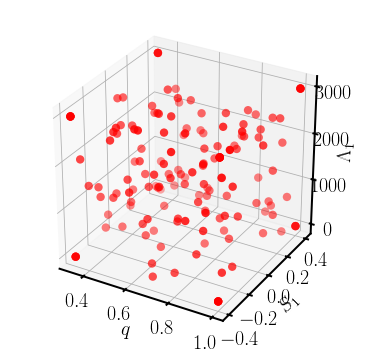

In [143]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [151]:
header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]]
There are 32 corners and 128 LHD points.
"""
np.savetxt('/Users/lackey/Research/gpsurrogate/data/teobtest40hz/params_trainset_corners_lhd.txt', params,
          header=header)

In [152]:
# Generate the randomly sampled set
Ndata = 1000
limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
params = doe.uniform_random_samples(Ndata, limits)

header = """The limits for [q, s1, s2, lamda1, lambda2] are
[[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]]
There are 1000 points. Each parameter is randomly sampled with a uniform distribution between the limits.
"""
np.savetxt('/Users/lackey/Research/gpsurrogate/data/teobtest40hz/params_testset1.txt', params,
          header=header)

# Methods for the training set

In [7]:
def get_waveform_from_training_set(f, i, mtot=2., distance=1.):
    """Get waveform in geometric units corresponding to group h_i in the hdf5 file.
    
    Parameters
    ----------
    f : hdf5 file handle
    i : index of waveform
    mtot : float 
        Total mass (M_sun) used to generate the lalsimulation waveform.
    distance : float
        Distance (Mpc) used to generate the lalsimulation waveform.
    
    Returns
    -------
    params : 1d array
        Waveform parameters (smallq, s1, s2, lambda1, lambda2).
    h : Waveform
    """
    # The parameters (q, s1, s2, lambda1, lambda2)
    params = f['configurations'][i]
    # Convert bigq to smallq
    #params[0] = 1.0/params[0]
    
    wave_str = 'h_'+str(i)
    time = f[wave_str]['t'][:]
    amp = f[wave_str]['amp'][:]
    # The phase grows monotonically
    phase = f[wave_str]['phi'][:]
    
    hphys = wave.Waveform.from_amp_phase(time, amp, phase)
    
    # Rescale to geometric units
    h = wave.physical_to_dimensionless_time(hphys, mtot, distance)
    
    return params, h

In [8]:
def time_at_max_amp(time, amp):
    """Find the time corresponding to the maximum amplitude.
    This function interpolates between data points using a 2nd-order spline,
    before finding the maximum.
    """
    nsamp = len(amp)
    
    # Find index of maximum amplitude
    imax = np.argmax(amp)
    # Associated time used as initial guess in numerical maximization
    tmax = time[imax]
    
    if imax==nsamp-1:
        raise Exception, "Maximum amplitude is at last data point. Can't calculate global maximum."
    
    # Range of parameters to interpolate
    # (Use no more than the 7 points surrounding the max point.)
    istart = imax-3
    iend = min(len(amp)-1, imax+4)
    
    # Just interpolate a small number of points surrounding imax
    tlist = time[istart:iend]
    alist = amp[istart:iend]
    
    # Use 2nd order interpolation
    # because it's safer and gives pretty much the same results as higher order interpolation.
    # Note: A spline is not just a local quadratic fit of 3 points. 
    # It matches derivatives between local quadratics.
    # So, the answer changes as you add more points to tlist and alist.
    negampoft = interpolate.UnivariateSpline(tlist, -1.0*alist, k=2, s=0)
    
    # Find the minimum, starting the search at tmax
    result = optimize.minimize(negampoft, tmax)
    return result.x[0]

In [32]:
class ConditionedWaveform(object):
    """Methods for conditioning a time-domain Waveform object
    to be used in a frequency-domain training set.
    """
    
    def __init__(self, h):
        """
        """
        # Original waveform not to be manipulated
        self.h_orig = h
        # Copy of the waveform for manipulation
        self.h = h.copy()

    def resample_uniform(self, delta_t, order=2):
        """Resample waveform with spacing delta_t.
        Includes first sample, but does not necessarily include last sample.
        """
        xs = np.arange(self.h.x[0], self.h.x[-1], delta_t)
        self.h.resample(xs, order=order)
        
    def window_freq_on(self, winon_i, winon_f, win='planck'):
        self.h = window.window_freq_on(self.h, winon_i, winon_f, win=win)
        
    def window_freq_off(self, winoff_i, winoff_f, win='planck'):
        self.h = window.window_freq_off(self.h, winoff_i, winoff_f, win=win)
        
    def extend_with_zeros(self, n_ext):
        """Extend the uniformly resampled waveform with zeros so the total length is n_ext.
        The extended amplitudes will be zeros.
        The extended phases will be continuous with the last sample.
        
        WARNING: The waveform must be *uniformly* sampled.
        WARNING: If you are going to take a FFT, you might want n_ext to be a power of 2 for speed.
            This is the reason for the integer argument n_ext instead of the length in units of time.
        """
        # Original length
        n_orig = len(self.h.x)
        
        # Array of extended times
        x0 = self.h.x[0]
        delta_t = self.h.x[1] - self.h.x[0]
        times_ext = x0 + delta_t*np.arange(n_ext)
        
        # Extended amplitudes
        amp_ext = np.zeros(n_ext)
        amp_ext[:n_orig] = self.h.amp
        
        # Extended phases
        # (Make phase continuous even when amplitude goes to zero)
        phase_ext = np.ones(n_ext)*self.h.phase[-1]
        phase_ext[:n_orig] = self.h.phase
        
        self.h = wave.Waveform.from_amp_phase(times_ext, amp_ext, phase_ext)
        
    def fourier_transform(self):
        """Fourier transform the *uniformly* resampled waveform.
        This is a standard FFT tha treats the first time sample as t=0. 
        You will have to do a frequency-domain time shift later if you want a 
        different definition for t=0.
        """
        self.h = wave.fourier_transform_uniform_sampled_waveform(self.h)
        
    def zero_coalescence_time_in_frequency_domain(self, f_coalescence=None, max_amp=None):
        """Set the coalescence time to t=0, where coalescence time is determined by:
        1. Time corresponding to the frequency [f = (dphase/dt)/(2pi)] f_coalescence.
        2. Time corresponding to maximum amplitude.
        """
        t_start = self.h_orig.x[0]
        
        # Find coalescence time
        if (f_coalescence is not None) and (max_amp is None):
            t_coal = train.calculate_coalescence_time(self.h_orig, f_coalescence)
        elif (max_amp is not None) and (f_coalescence is None):
            t_coal = time_at_max_amp(self.h_orig.x, self.h_orig.amp)
        else:
            raise Exception, "You must pick either 'f_coalescence' or 'max_amp'."
        
        # Shift phase of Fourier-transformed waveform.
        dt_insp = t_coal - t_start
        self.h.phase += 2.*np.pi*self.h.x*dt_insp
        
    def log_spaced_in_frequency_domain(self, trunc_i, trunc_f, npoints=10000):
        wave.resample_uniform(self.h, xi=trunc_i, xf=trunc_f, npoints=npoints, spacing='log', order=2)
        
    def difference_with_taylorf2(self, params):
        """Compare with TaylorF2 waveform.
        """
        q, spin1z, spin2z, lambda1, lambda2 = params
        mf = self.h.x
        h_ref = taylorf2.dimensionless_taylorf2_waveform(
            mf=mf, q=q,
            spin1z=spin1z, spin2z=spin2z,
            lambda1=lambda1, lambda2=lambda2)
    
        h_ref.add_phase(remove_start_phase=True)
        npoints = len(mf)
        dh = train.lnamp_phase_difference(self.h, h_ref, npoints=npoints, spacing='log', order=2)
        return h_ref, dh

In [112]:
def condition_eob_waveform(
    h, params, delta_t, 
    winon_i, winon_f,
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', plots=False):
    """Generate a conditioned Frequency-domain waveform from an EOB waveform with arbitrary time samples.
    0. Resample the waveform.
    1. Window the beginning and end.
    2. Pad the end with zeros so all the waveforms in the training set have the exact same time samples.
    3. Fourier transform the waveform.
    4. Time shift waveform so t=0 corresponds to maximum amplitude.
    5. Resample the waveform, truncating the beginning and end to remove the windowing effect.
    
    Parameters
    ----------
    h : Waveform
        Uniformly sampled waveform.
    winon_i : Initial frequency of on window.
    winon_f : Final frequency of on window.
    winoff_i : Initial frequency of off window.
    winoff_f : Final frequency of off window. Should be less than the ending frequency of the waveform h.
    n_ext : int
        Number of samples for the extended (padded) waveform.
        All training set waveforms should have the same time samples.
        A power of 2 will make the Fourier transform efficient.
        If the phase of the Fourier-transformed waveform doesn't look correctly unwrapped,
        increase n_ext so that delta_f will be smaller.
    trunc_i : Initial frequency of the truncated waveform after Fourier transforming.
    trunc_f : Final frequency of the truncated waveform after Fourier transforming.
    npoints : int
        number of logarithmically-spaced samples for the final conditioned waveform.
    win : 'hann' or 'planck'
        Type of window to use.
    
    Returns
    -------
    h_tilde : Waveform
        The conditioned, Fourier-transformed, and resampled waveform.
    """
    condition = ConditionedWaveform(h)
    
    # 0. Resample the waveform
    condition.resample_uniform(delta_t)

    # 1. Window the waveform
    condition.window_freq_on(winon_i, winon_f, win=win)
    #condition.window_freq_off(winoff_i, winoff_f, win=win)
    if plots:
        #wave.plot_waveforms([condition.h], npoints=100000)
        #wave.plot_waveforms([condition.h], xi=h.x[-1]-1000, npoints=10000)
        fig, ax = wave.plot_waveforms([condition.h], hc=True, xi=h.x[-1]-1000, npoints=10000)
        title = '{:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(params[0], params[1], params[2], params[3], params[4])
        ax.set_title(title)
        ax.minorticks_on()
    
    # 2. Extend the waveform
    condition.extend_with_zeros(n_ext)
    #wave.plot_waveforms([condition.h], npoints=100000)
    
    # 3. Fourier transform
    condition.fourier_transform()

    # 4. Time shift to set the time of maximum amplitude to t=0.
    condition.zero_coalescence_time_in_frequency_domain(max_amp=True)
    #condition.zero_coalescence_time_in_frequency_domain(f_coalescence=0.01)
    
    # 5. Resample and truncate waveform
    condition.log_spaced_in_frequency_domain(trunc_i, trunc_f, npoints=npoints)
    
    # Zero the start phase of the truncated waveform
    condition.h.add_phase(remove_start_phase=True)
    hcond = condition.h
    
    # Compare with TaylorF2
    hf2, dh = condition.difference_with_taylorf2(params)
    
    if plots:
        fig, (ax1, ax2) = wave.plot_waveforms_fd([dh])
        ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
        ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
        ax2.set_xlabel(r'$Mf$')
        ax1.minorticks_on()
        ax2.minorticks_on()
        ax1.grid(which='both')
        ax2.grid(which='both')
        ax1.set_ylim(-6., 0.5)
    
    return hcond, hf2, dh

In [113]:
def condition_eob_training_set(
    orig_filename, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', plots=False, 
    mtot=2.0, distance=1.0):
    """Make a conditioned WaveformSet with waveforms from orig_filename.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    # WaveformSet objects for conditioned waveforms
    h_ts = ws.HDF5WaveformSet(h_filename)
    dh_ts = ws.HDF5WaveformSet(dh_filename)
    
    for i in range(nwave):
        print i, 
        params, h = get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        
        h_cond, hf2, dh = condition_eob_waveform(
            h, params, delta_t, 
            winon_i, winon_f, 
            n_ext,
            trunc_i, trunc_f, npoints=npoints,
            win=win, plots=plots)
    
        h_ts.set_waveform(i, h_cond, params)
        dh_ts.set_waveform(i, dh, params)
    
    f.close()
    h_ts.close()
    dh_ts.close()

# Make the training set

In [10]:
mflow = f_to_mf(40., 2.)
print mflow

delta_t = 10.
winon_i = mflow
#winon_f = 0.0004
#winon_f = 0.00045
winon_f = 0.00050

min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time
print n_ext
#print [2**i for i in range(25)]
trunc_i = winon_f
trunc_f = 0.03

0.000394039282043
17687982.9215
2097152


## Initial training set with 32 corners and 128 LHD samples

In [7]:
orig_filename = '../../data/teobtest40hz/TEOB_data_train_corners_lhd.hdf5'
h_filename = '../../data/teobtest40hz/h_train_corners_lhd.hdf5'
dh_filename = '../../data/teobtest40hz/dh_train_corners_lhd.hdf5'

traineob.condition_eob_training_set(
    orig_filename, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', plots=False, 
    mtot=2.0, distance=1.0)

 17687982.9215 2097152
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55

KeyError: "Unable to open object (Object 'h_55' doesn't exist)"

## 1d slice to check smoothness


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10

/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


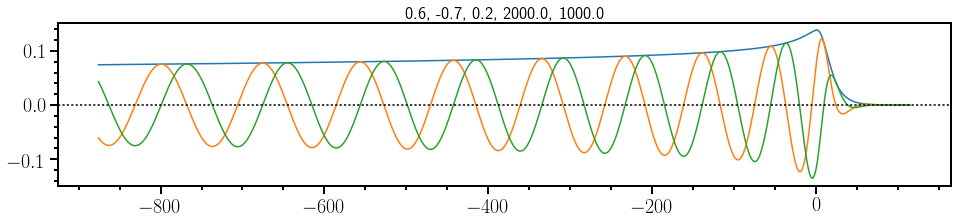

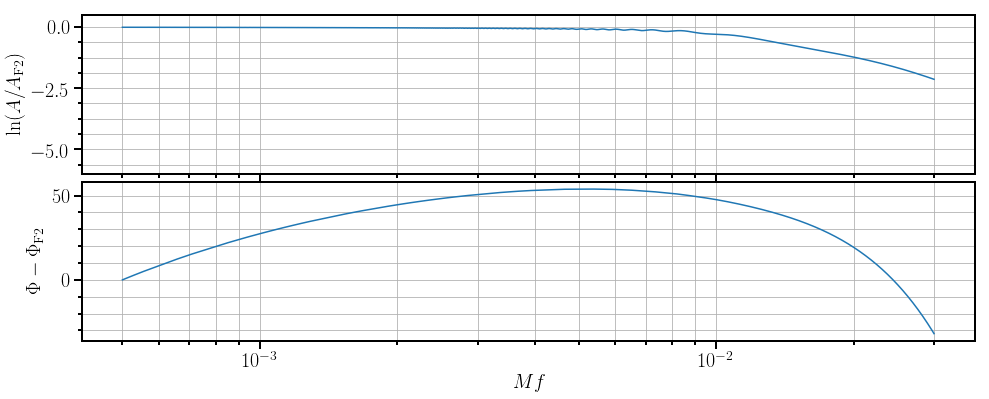

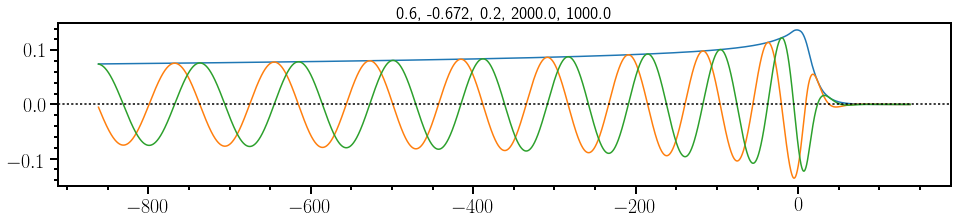

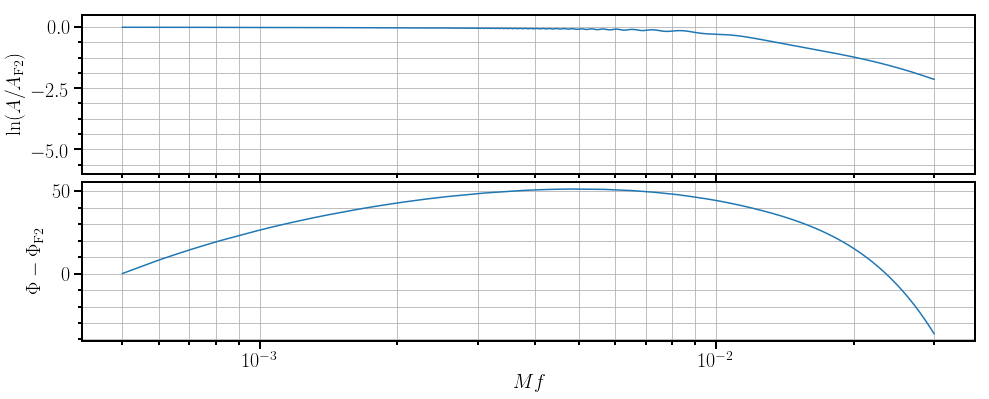

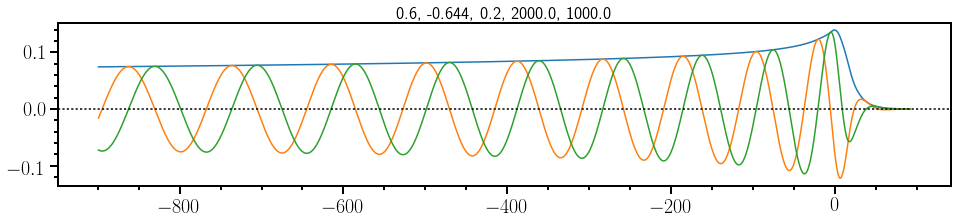

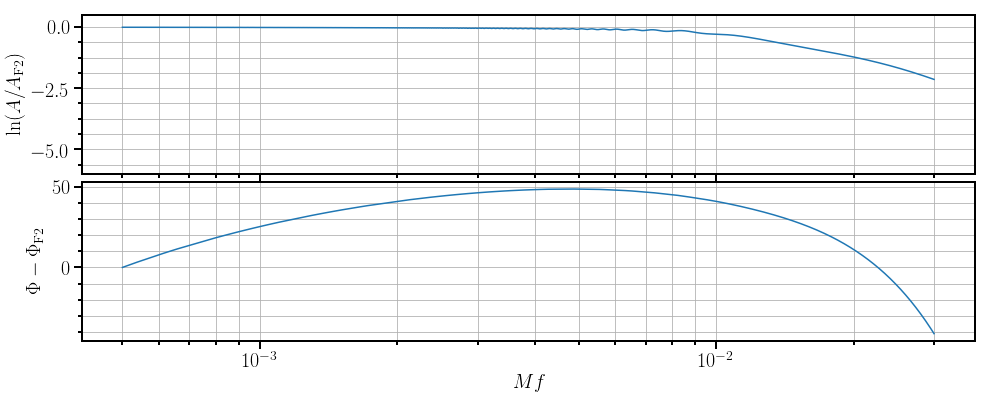

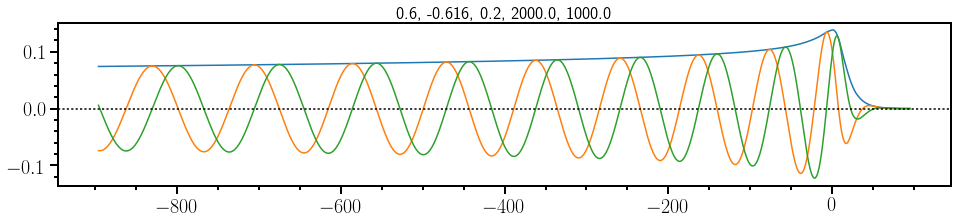

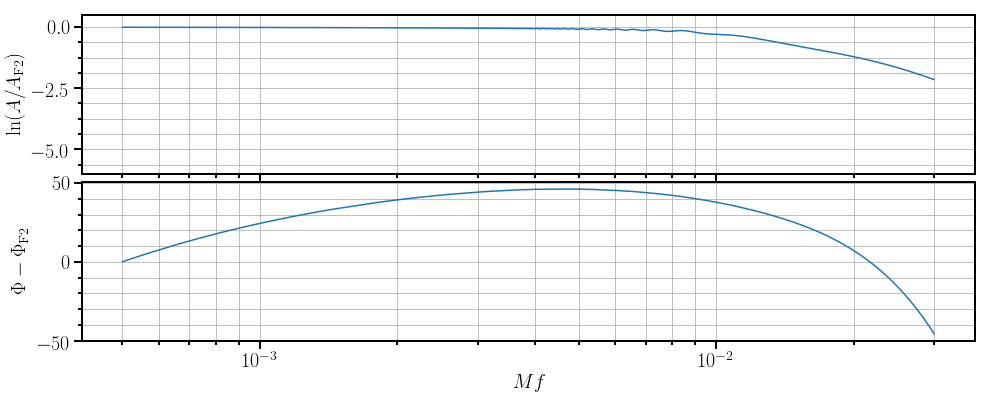

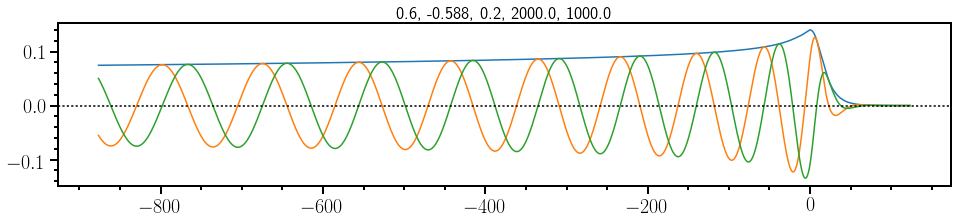

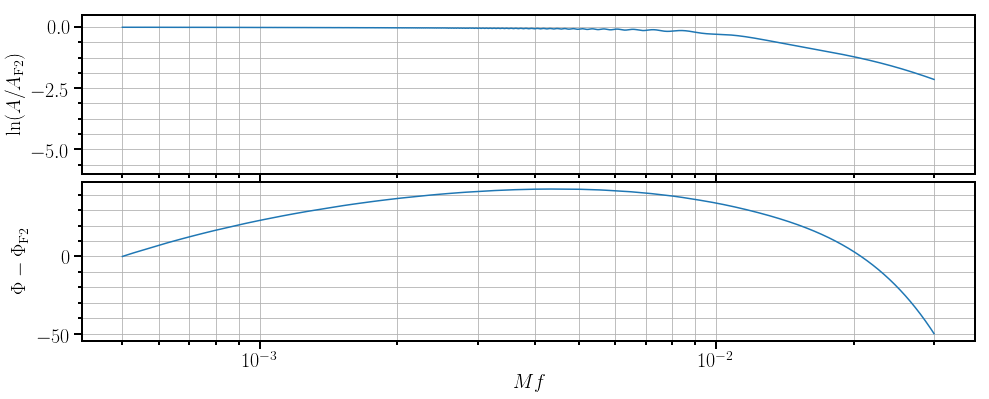

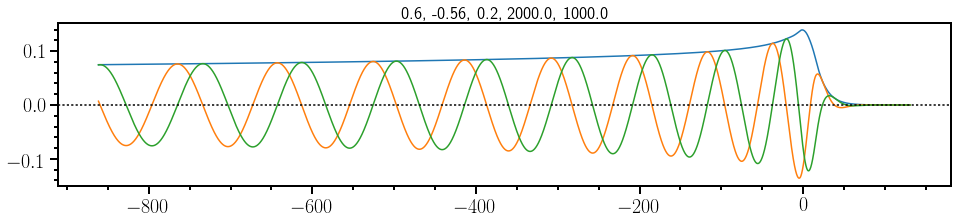

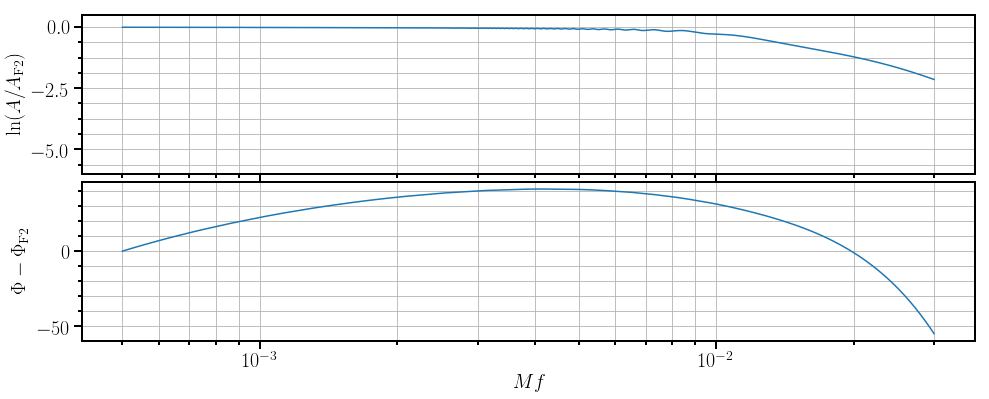

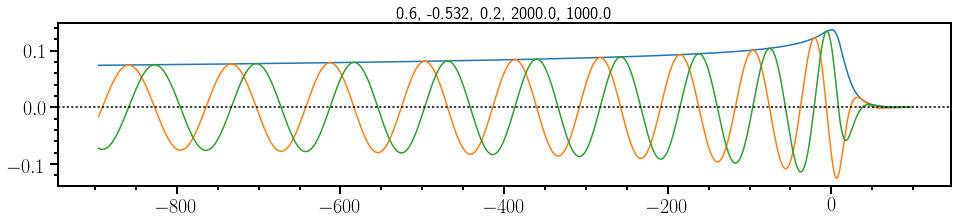

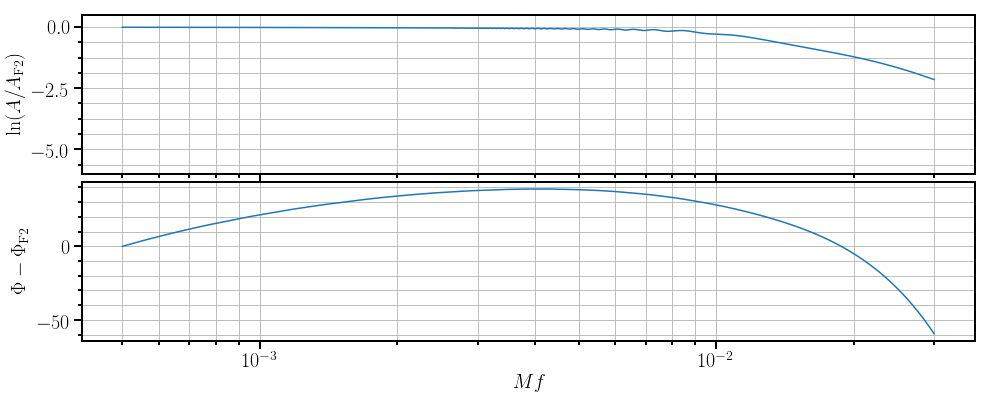

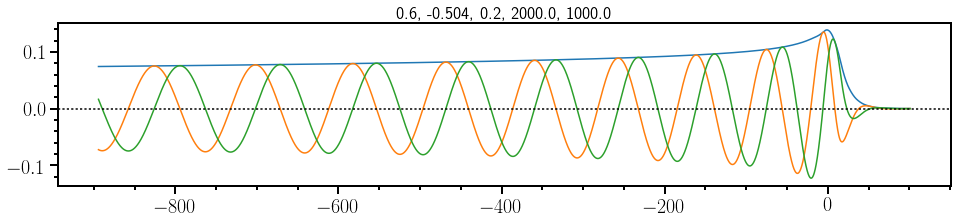

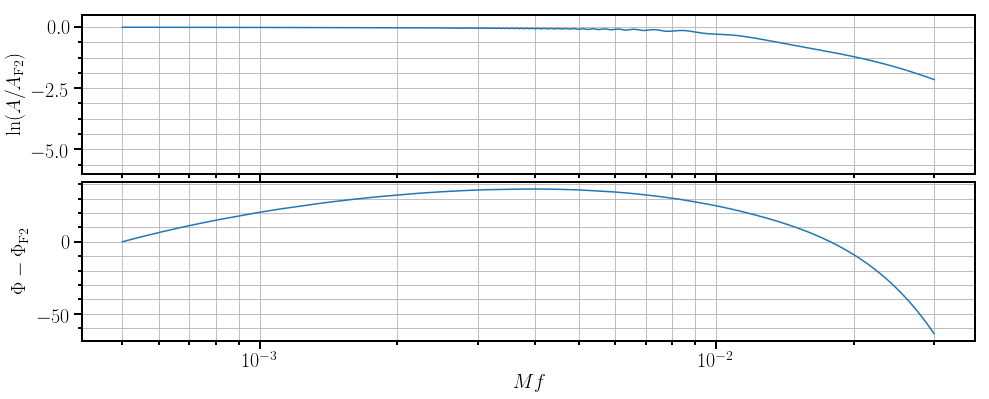

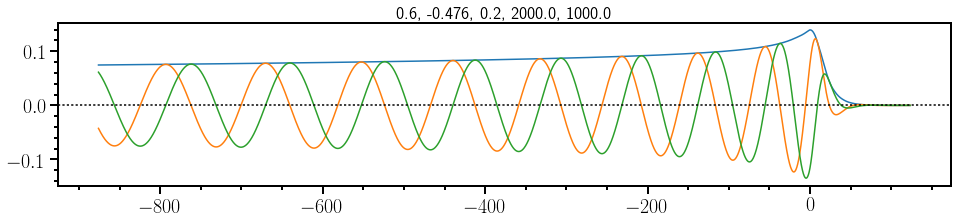

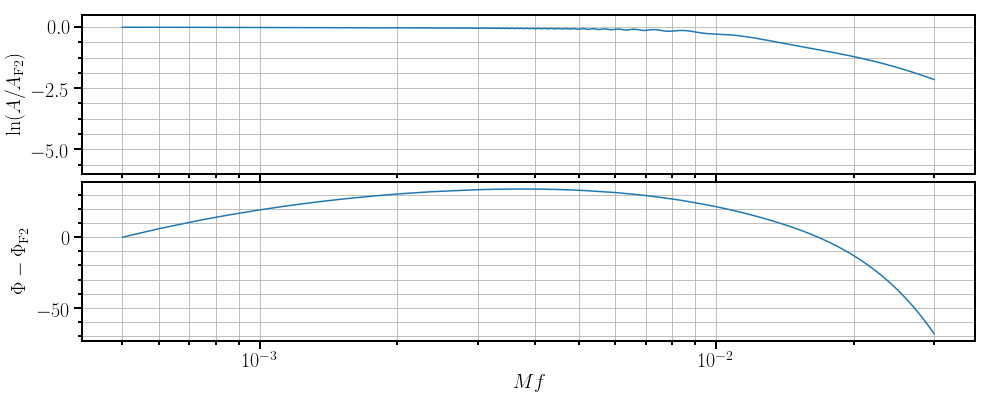

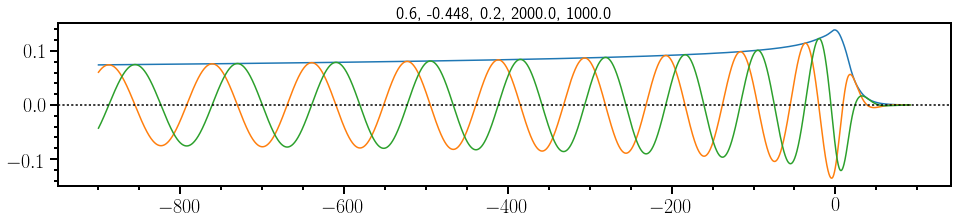

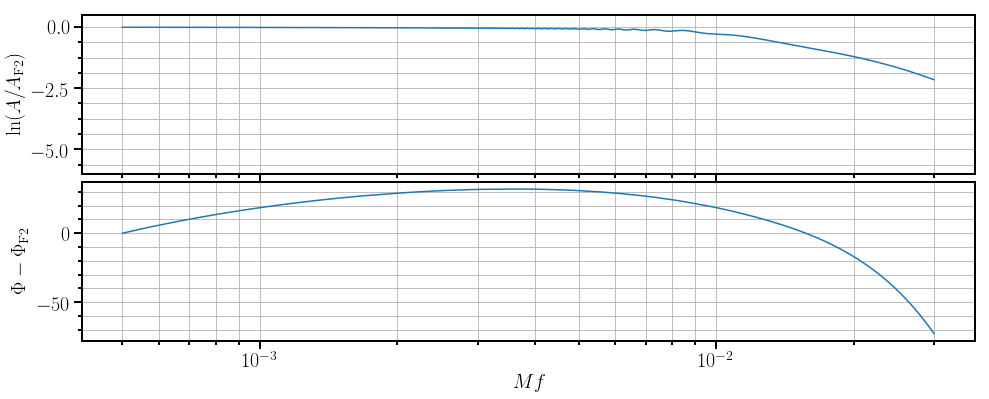

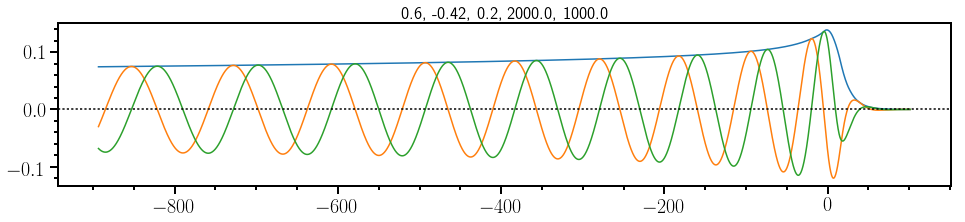

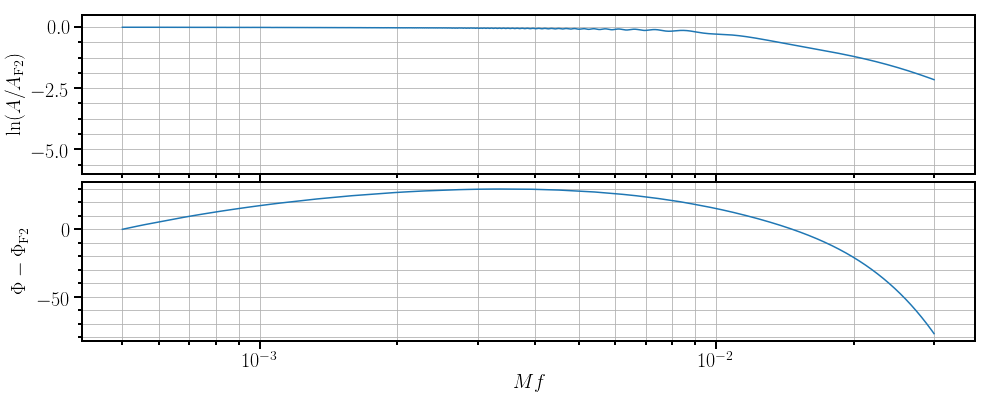

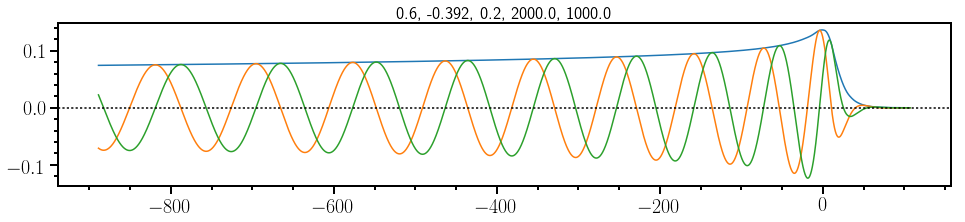

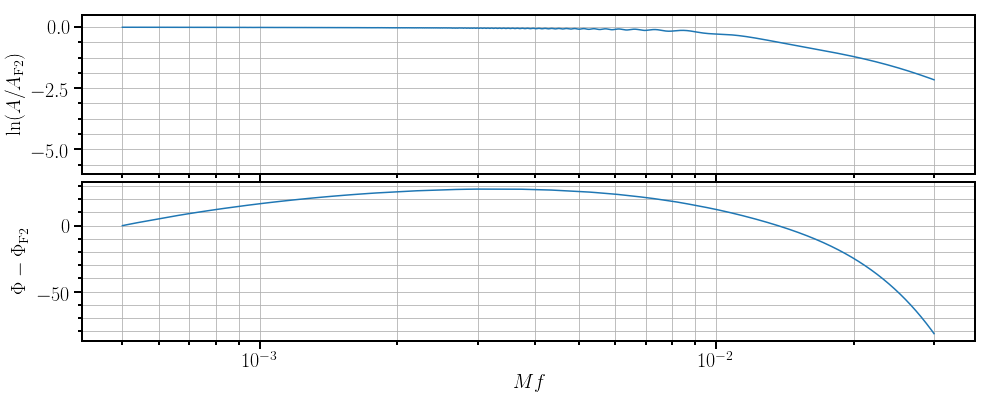

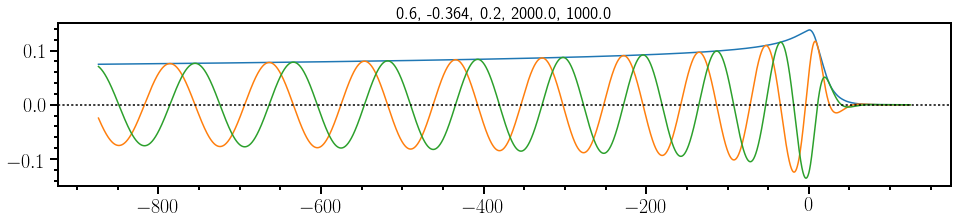

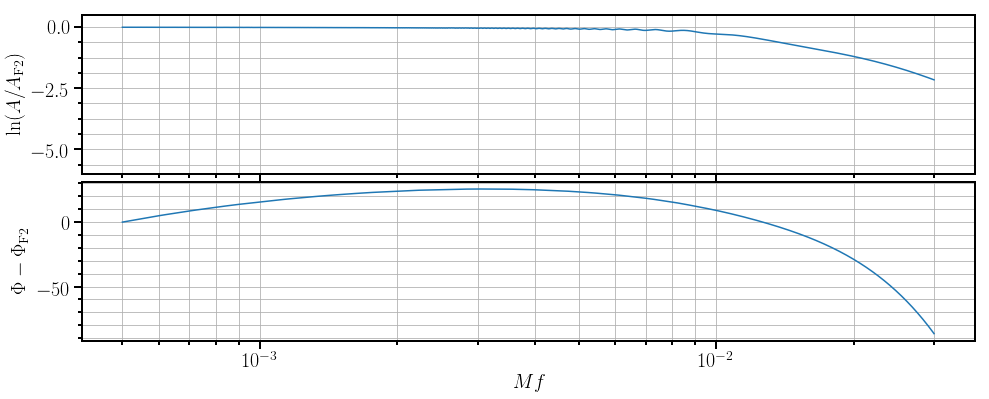

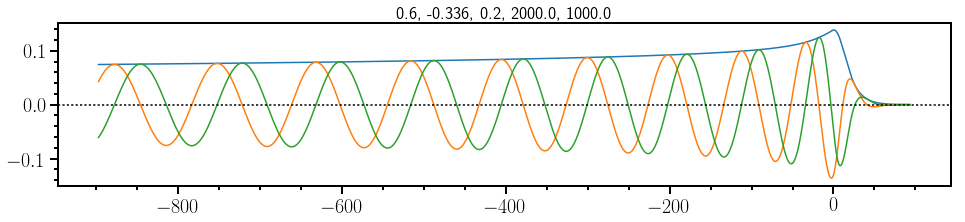

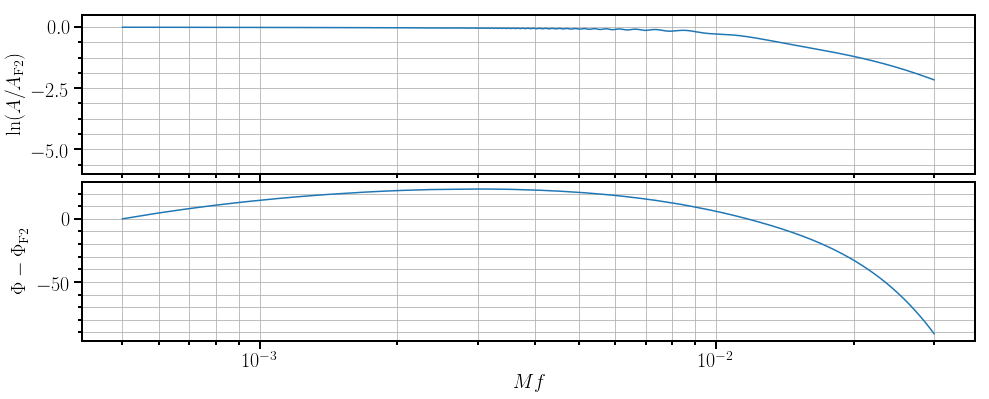

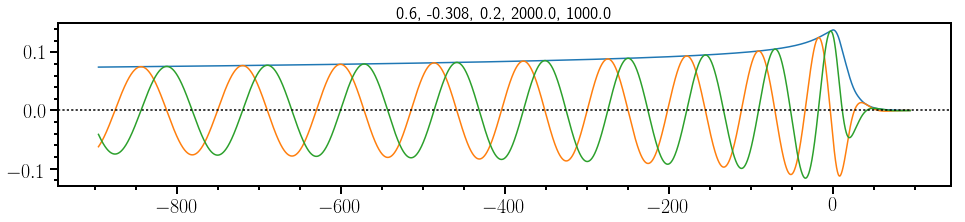

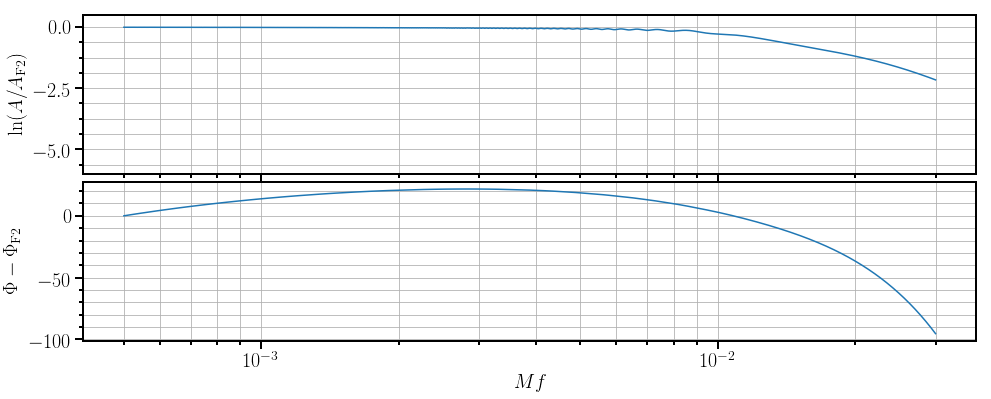

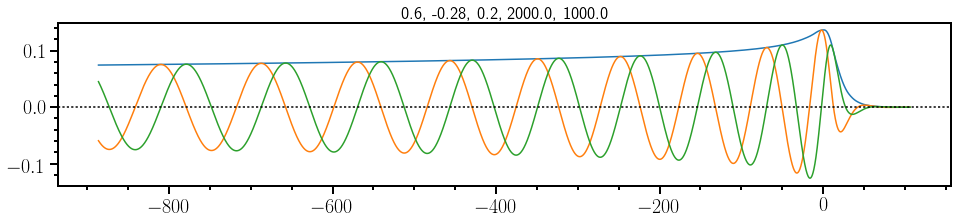

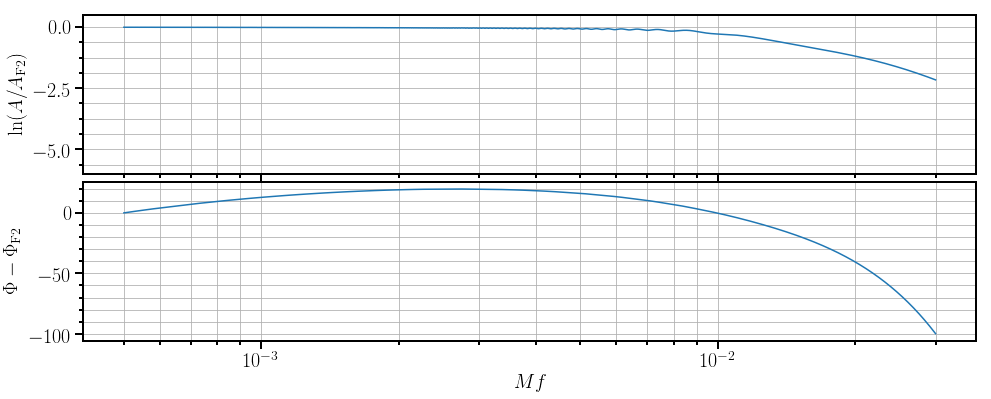

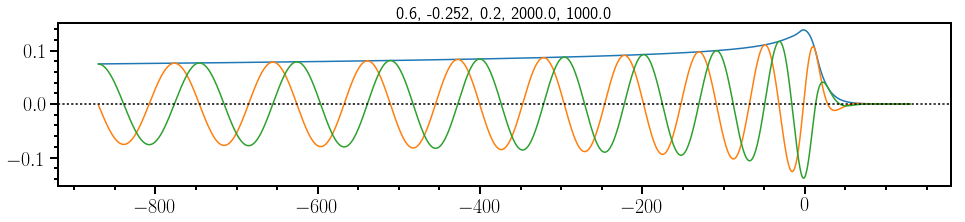

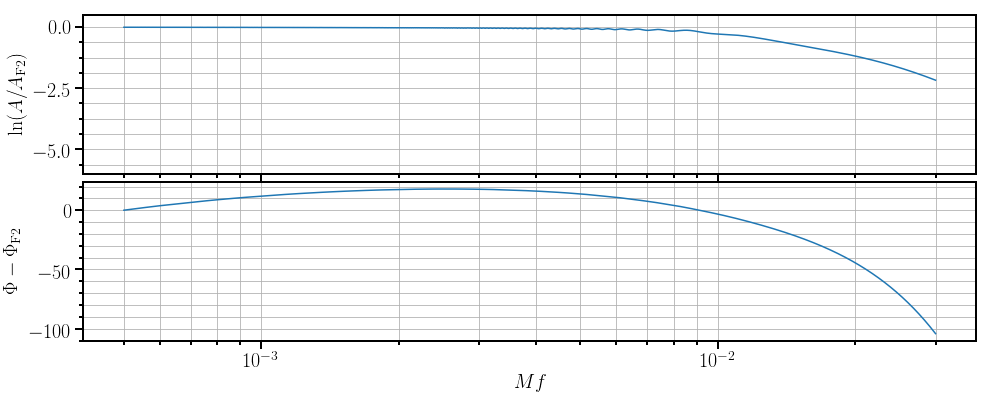

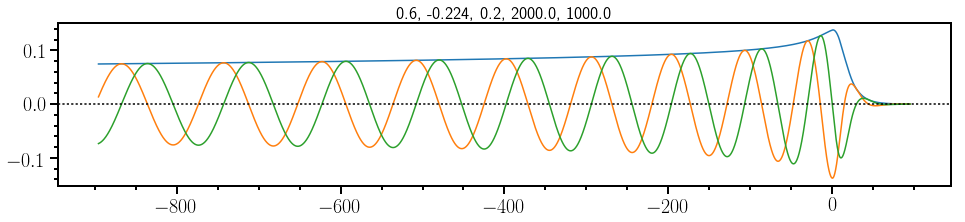

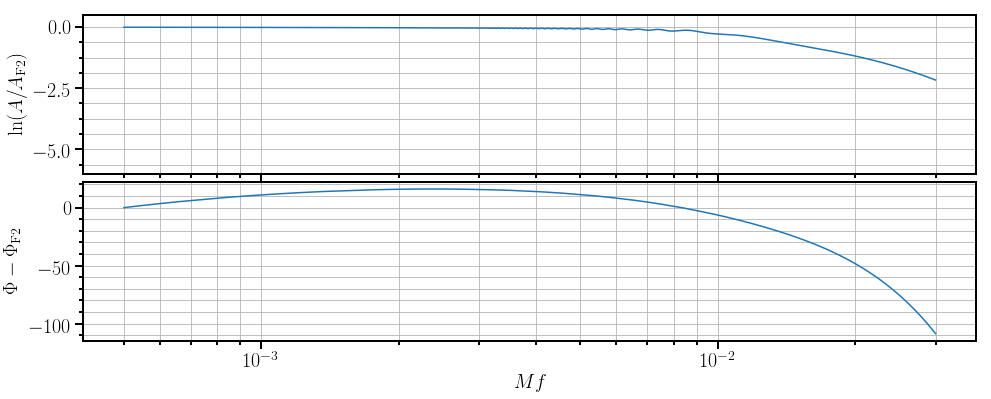

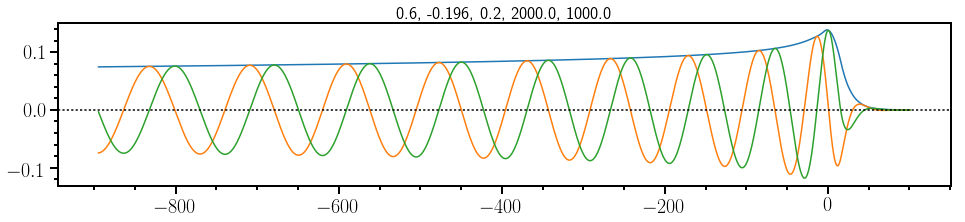

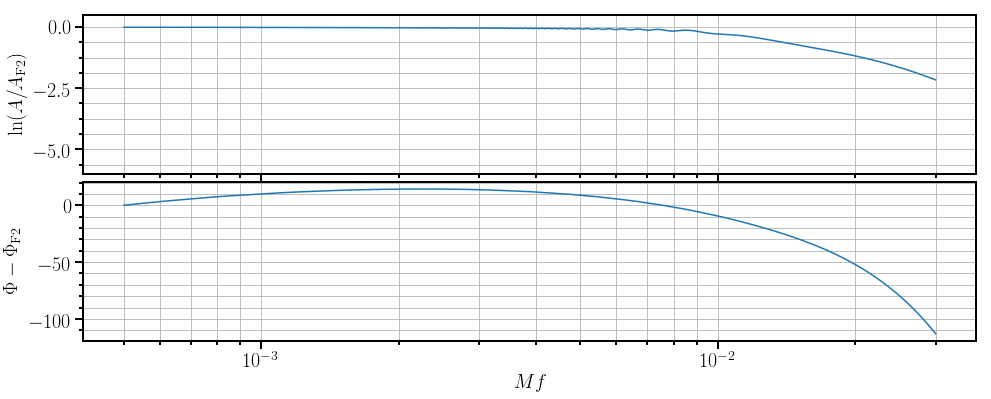

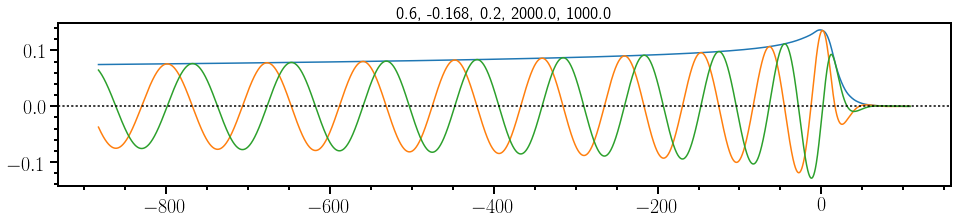

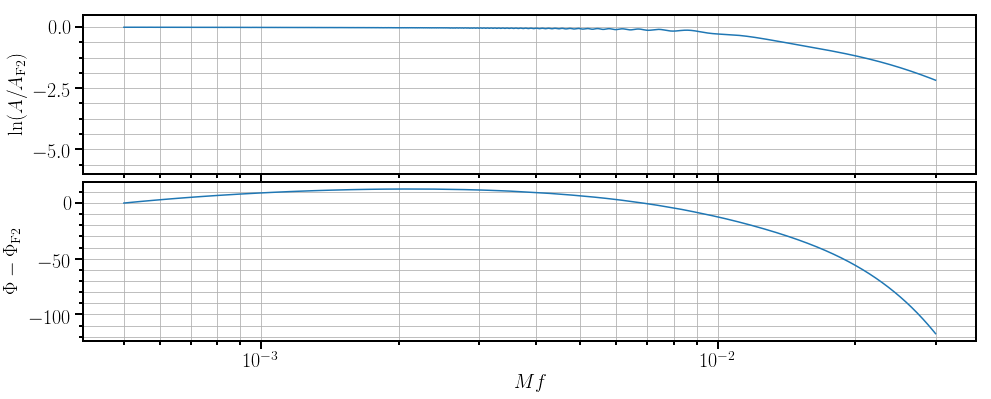

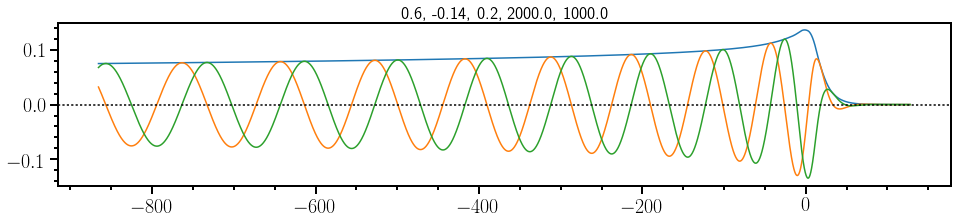

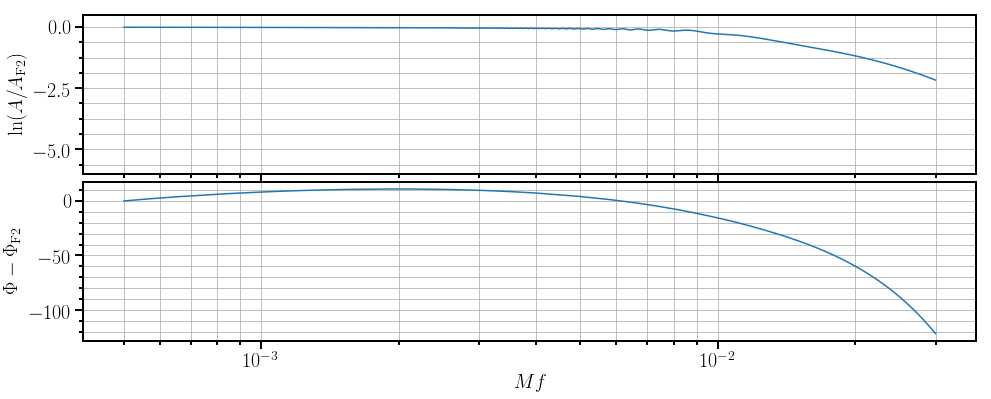

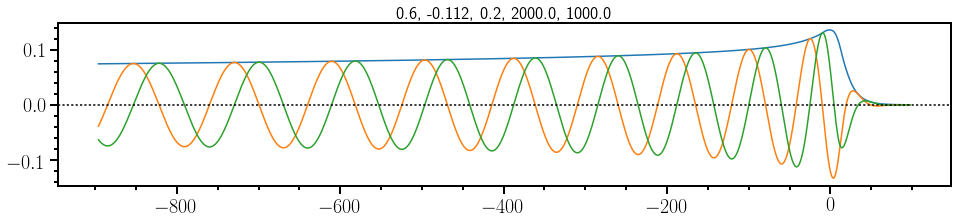

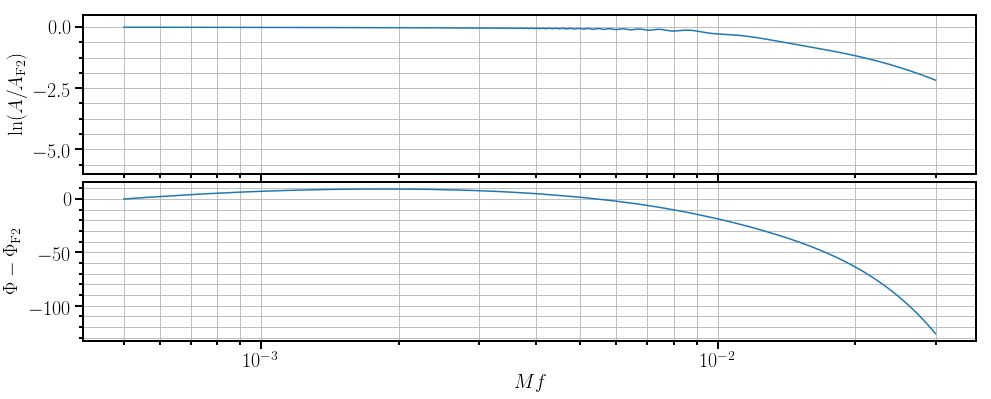

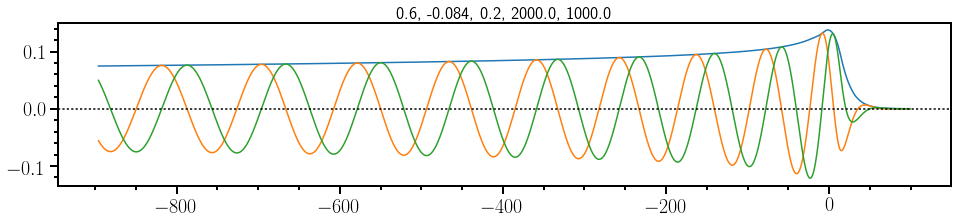

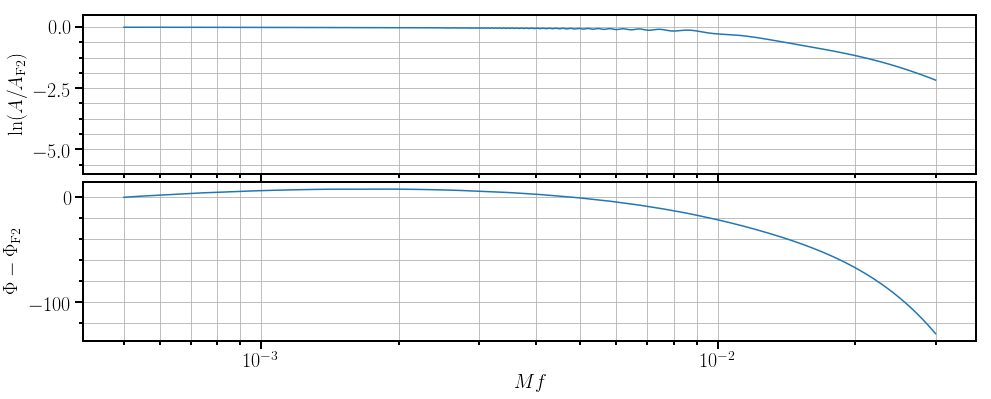

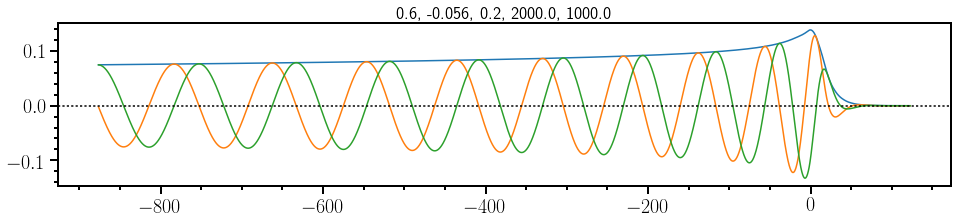

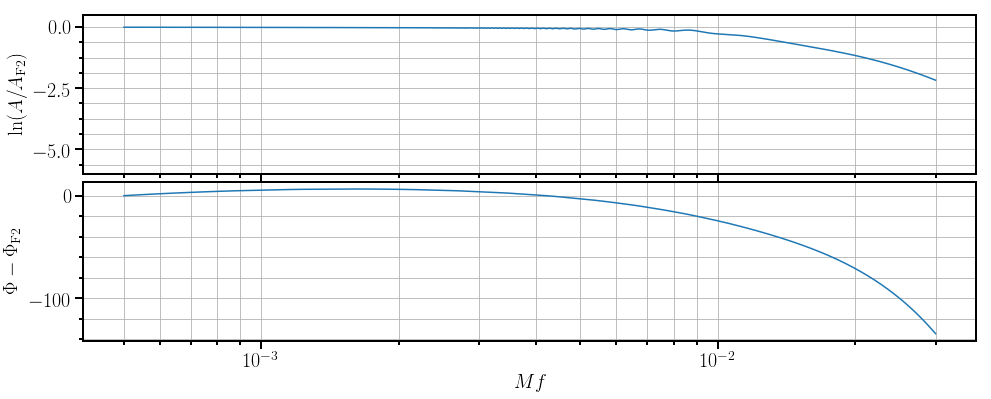

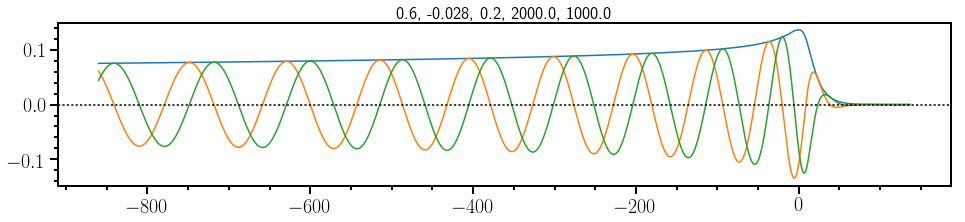

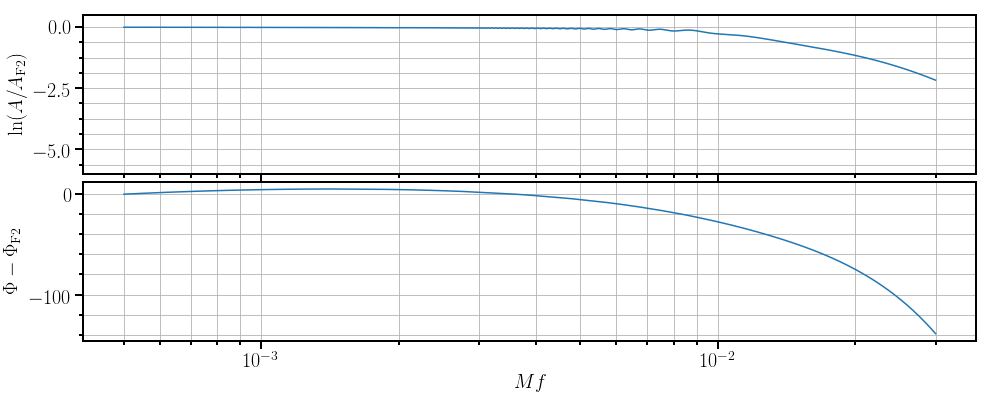

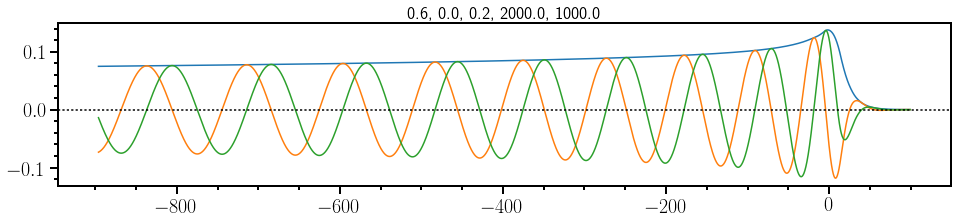

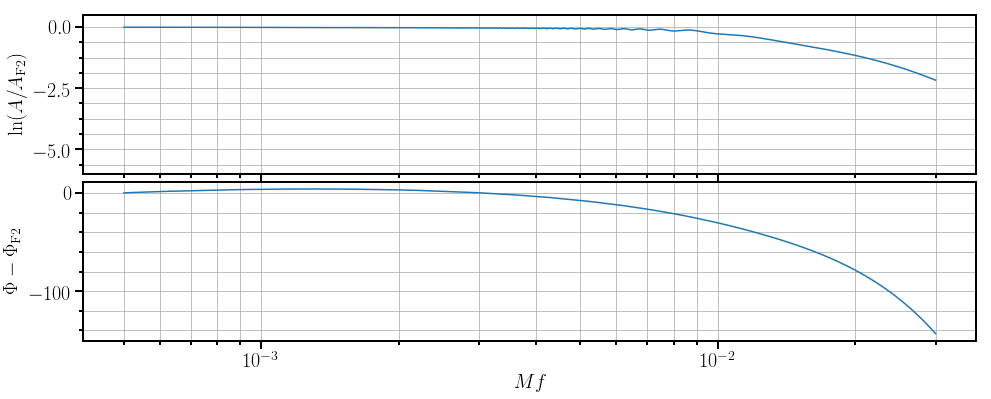

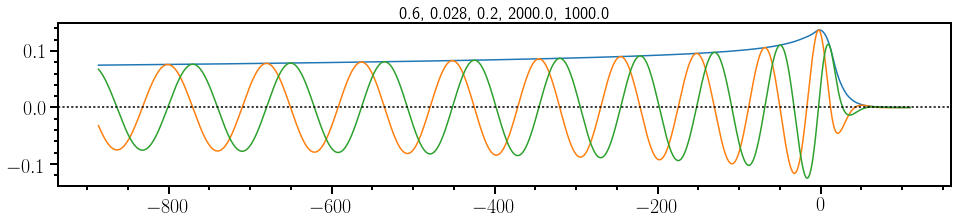

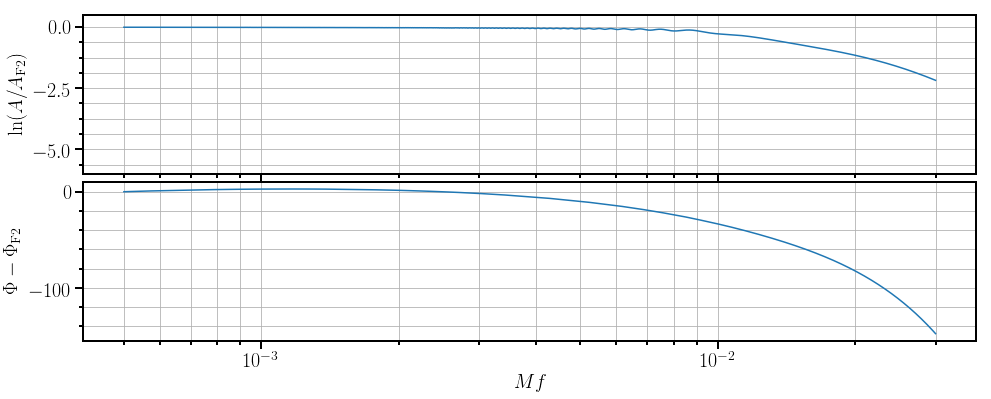

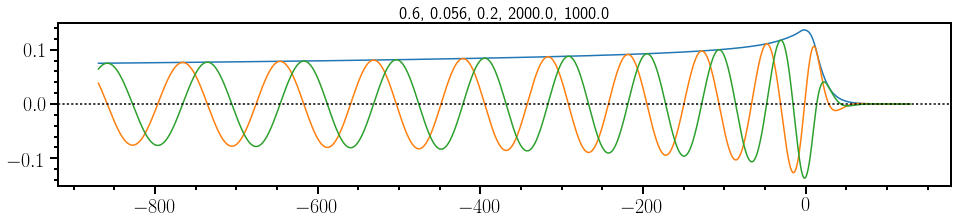

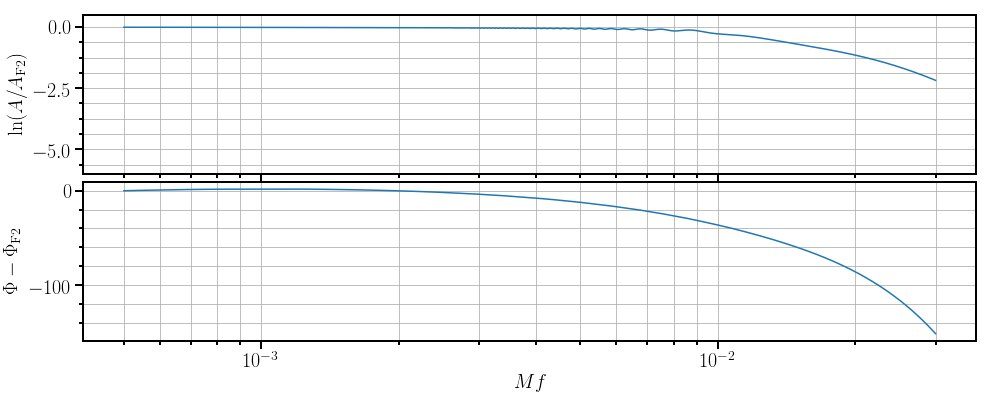

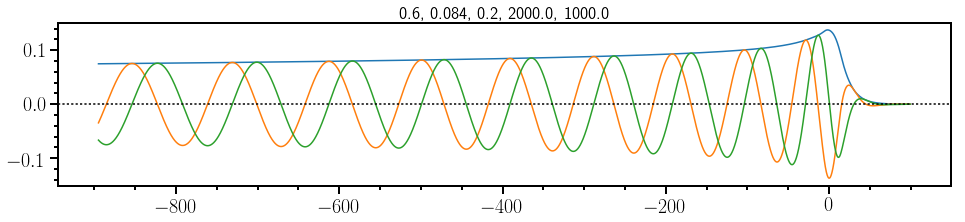

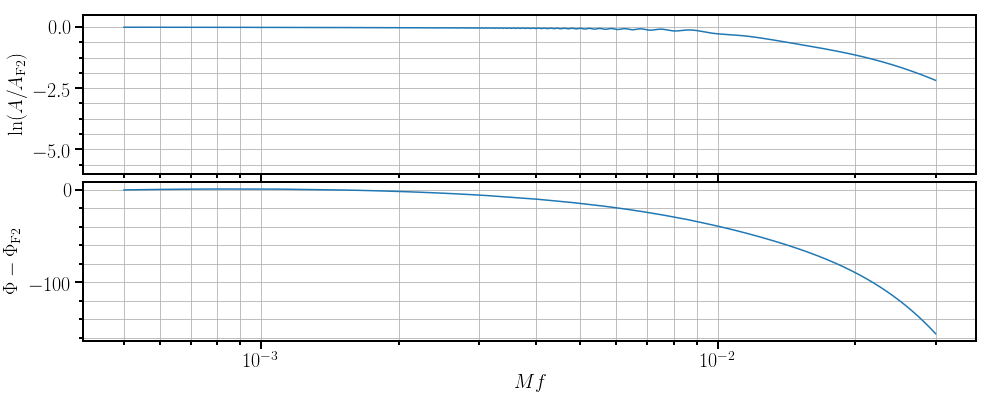

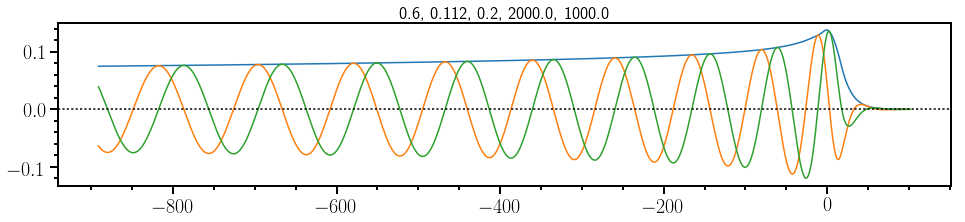

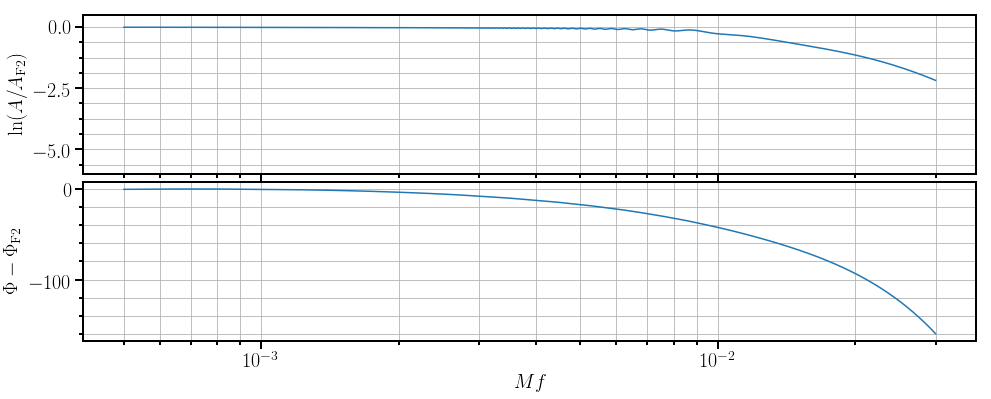

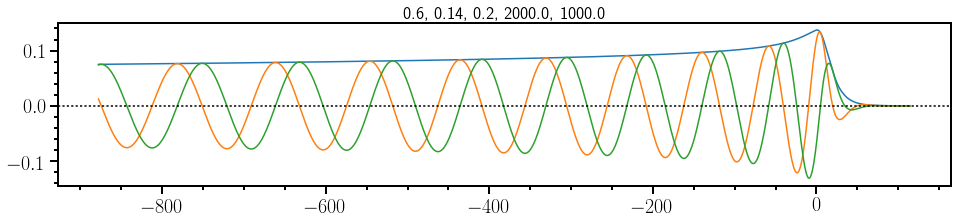

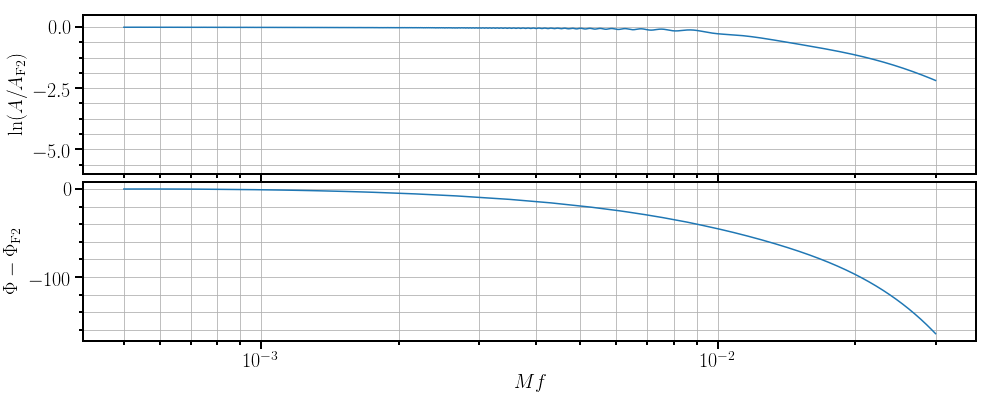

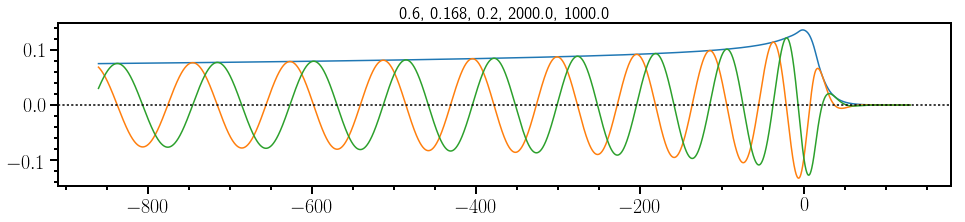

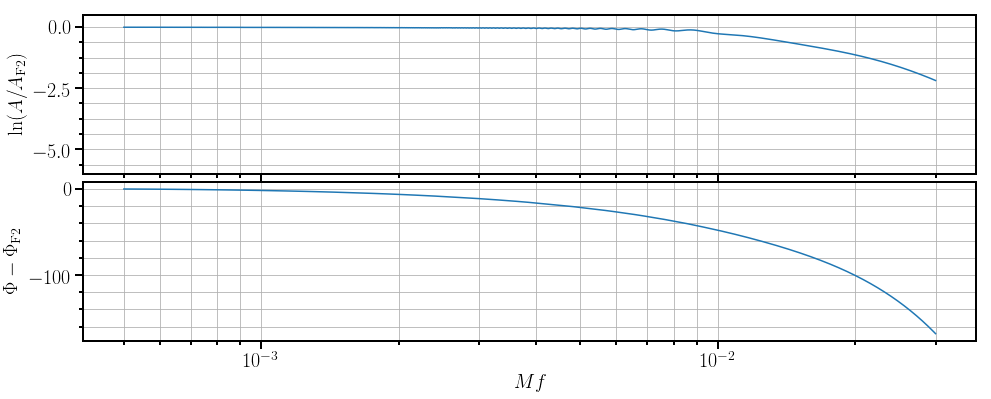

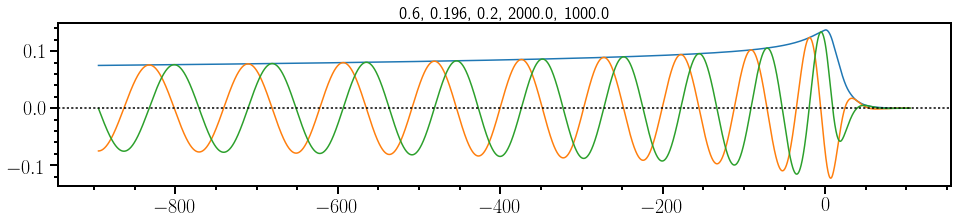

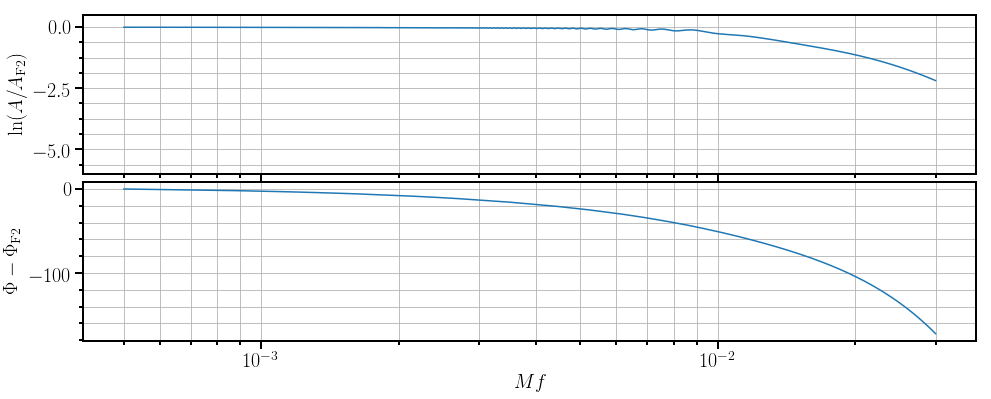

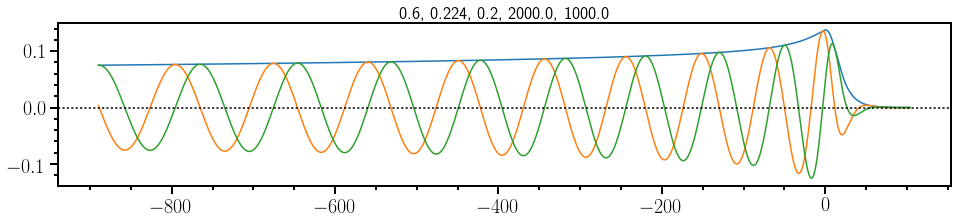

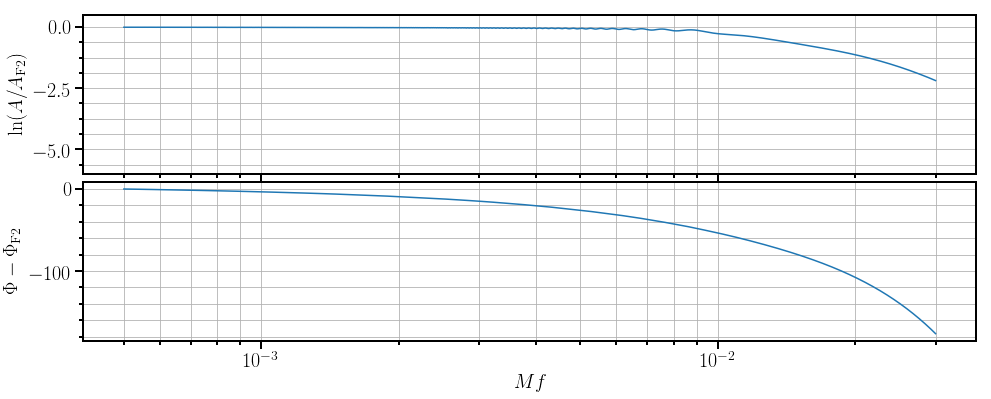

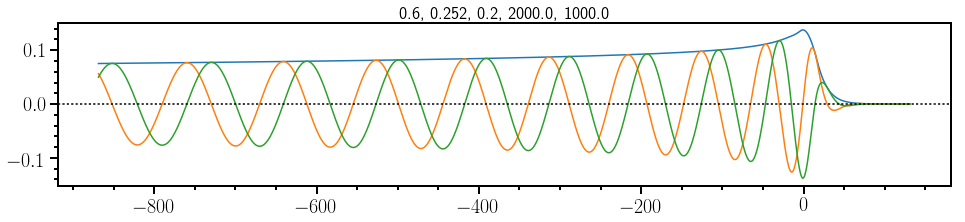

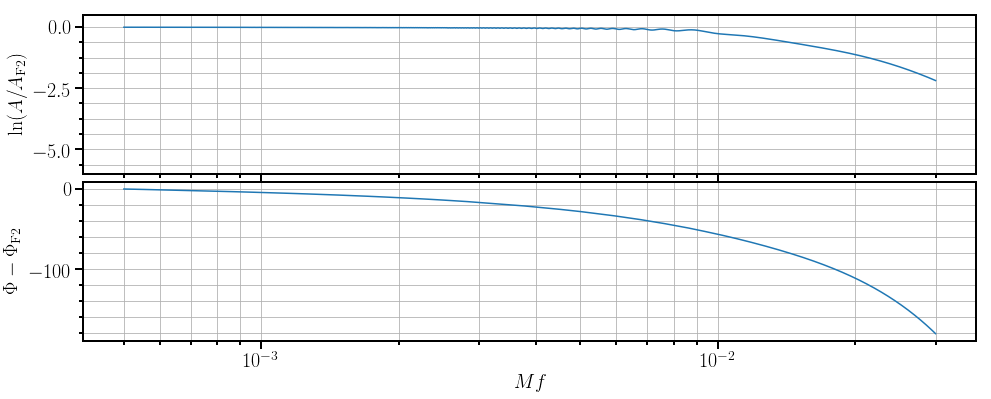

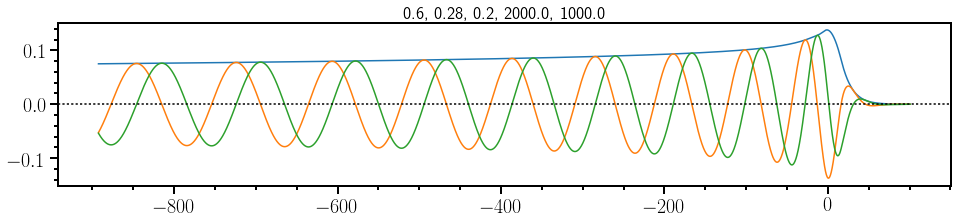

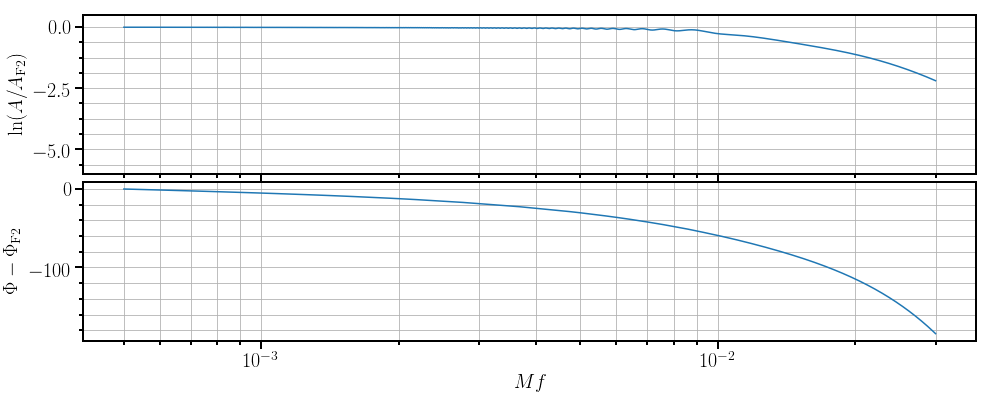

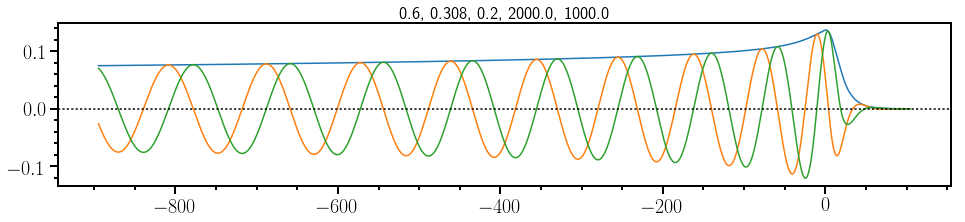

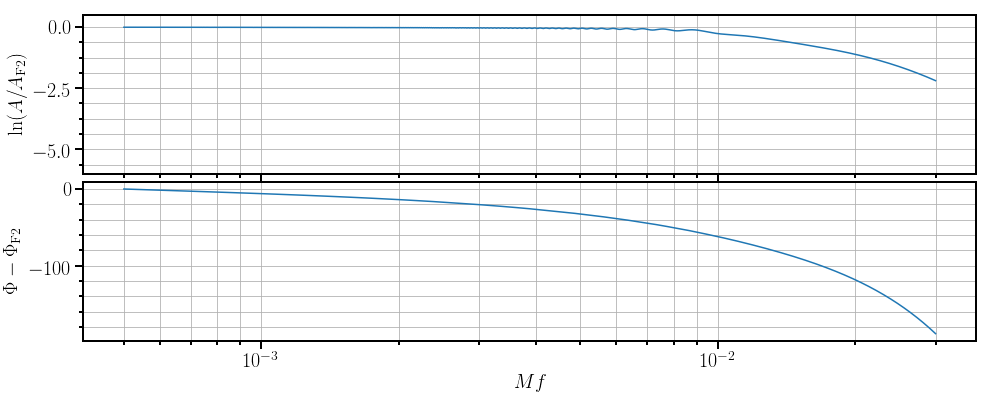

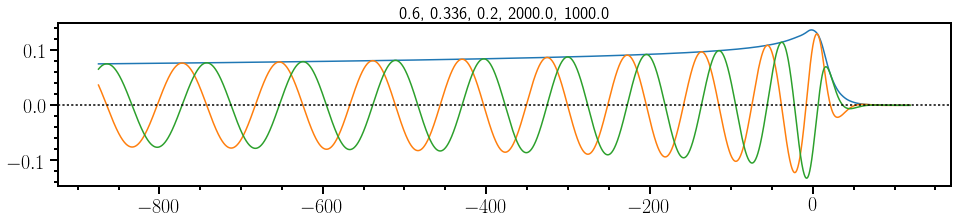

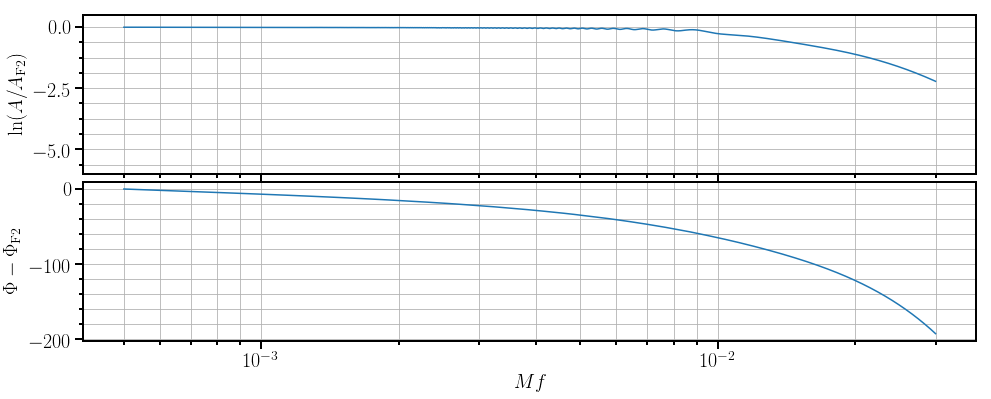

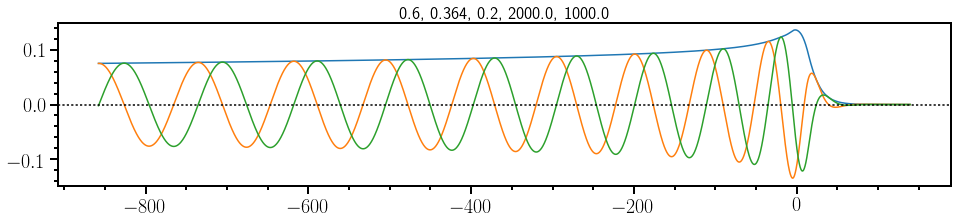

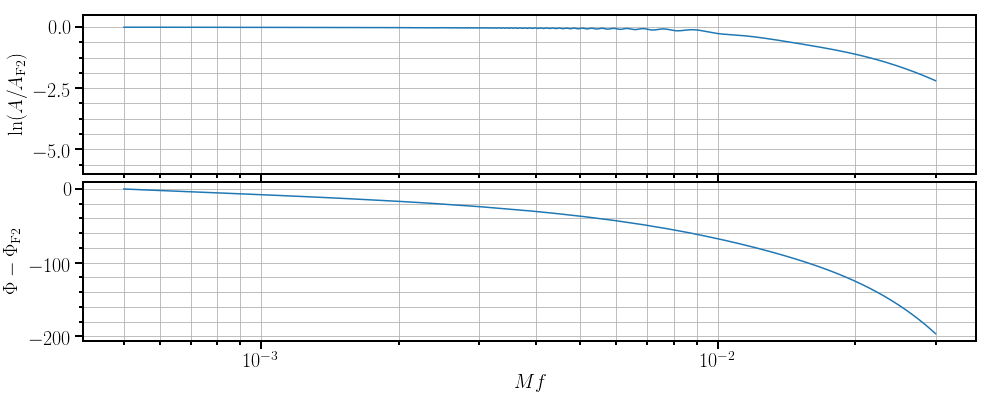

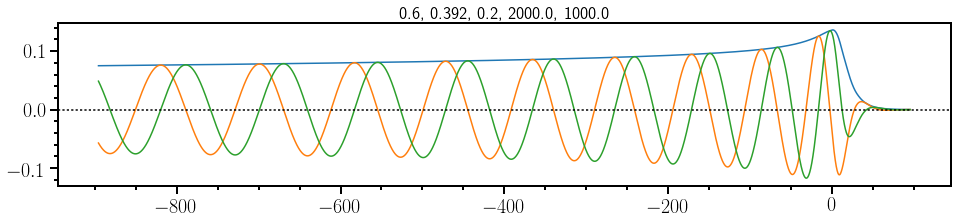

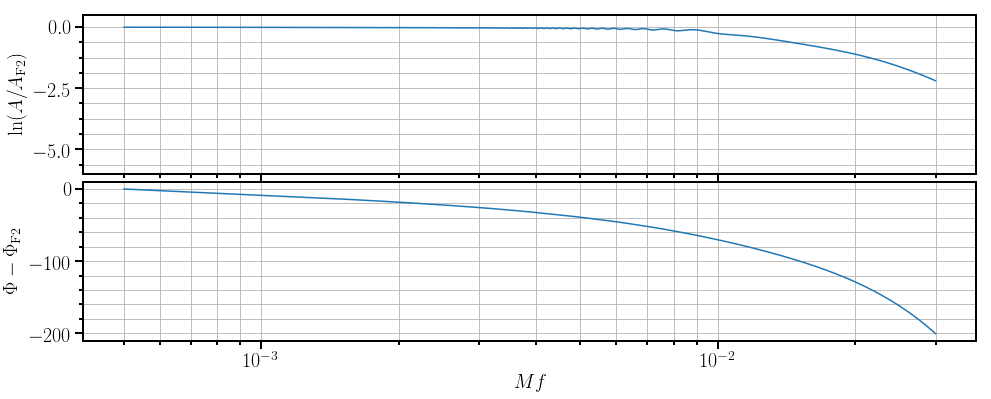

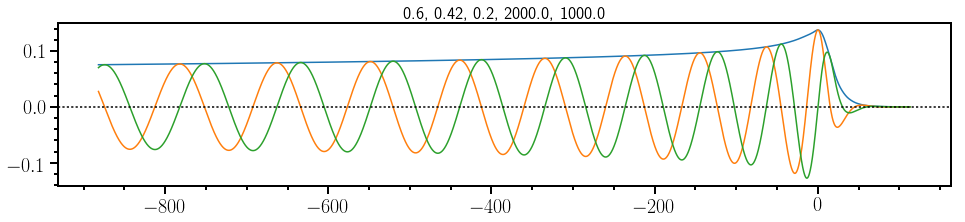

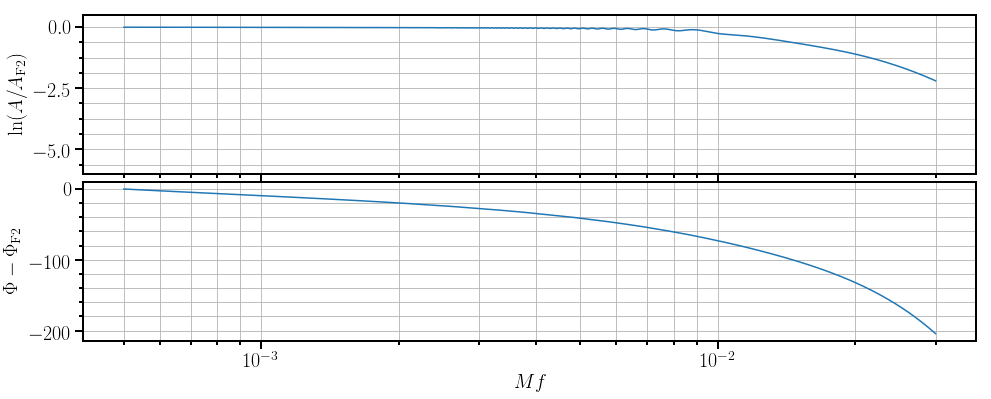

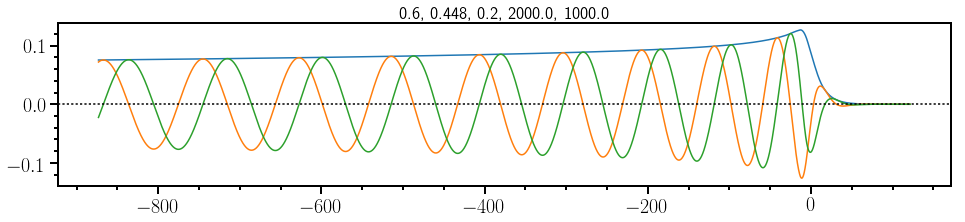

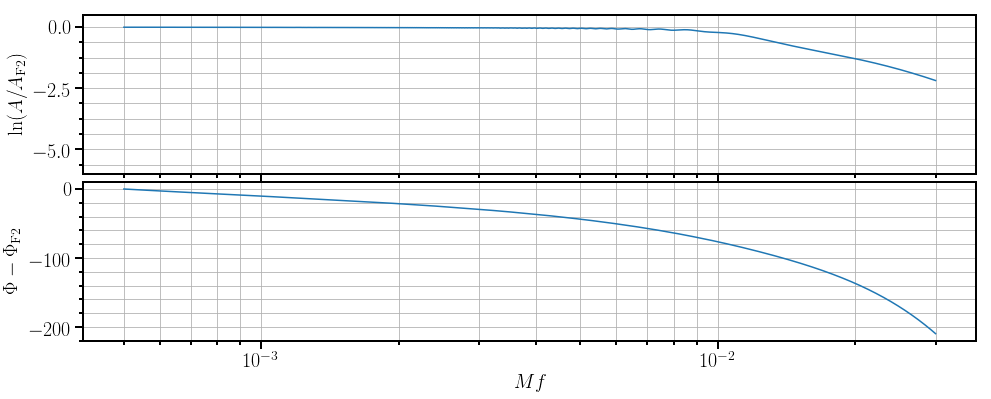

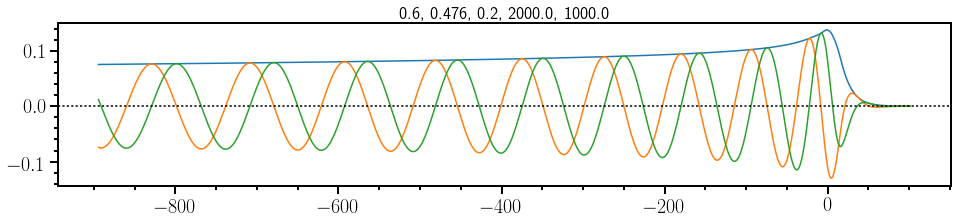

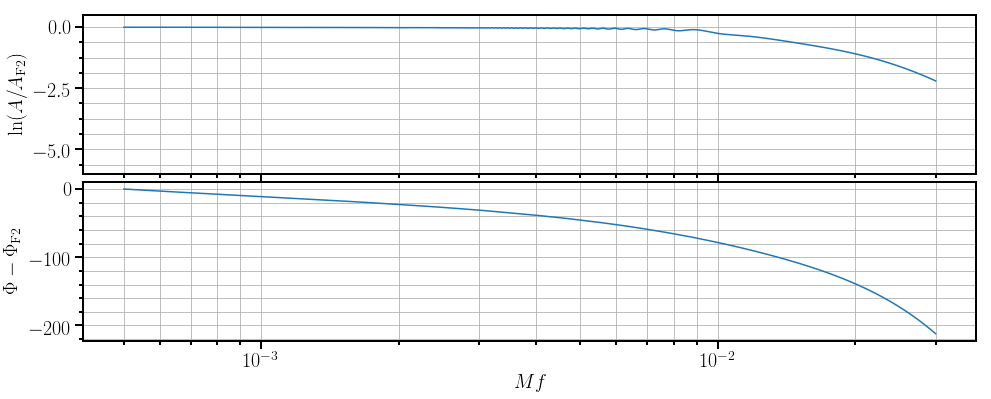

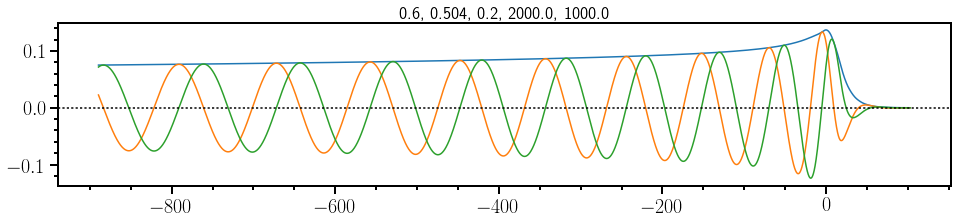

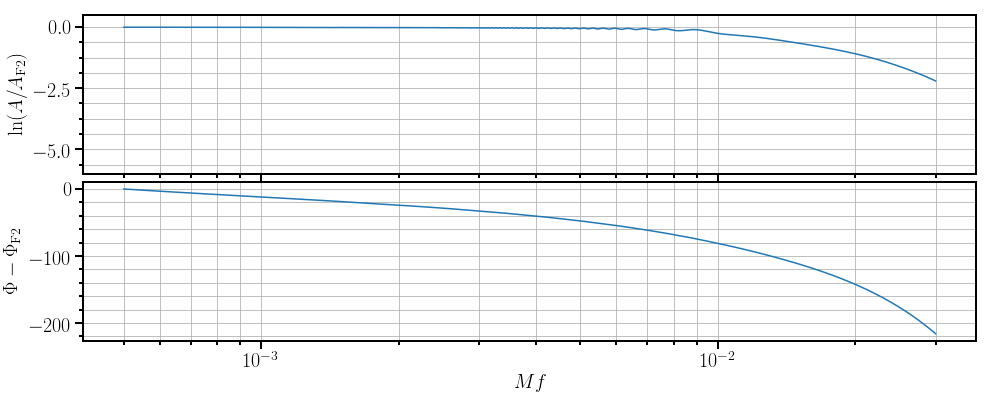

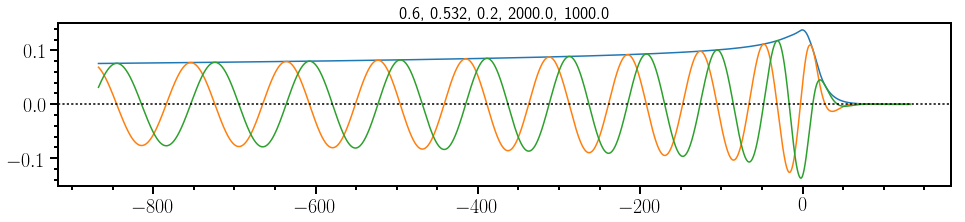

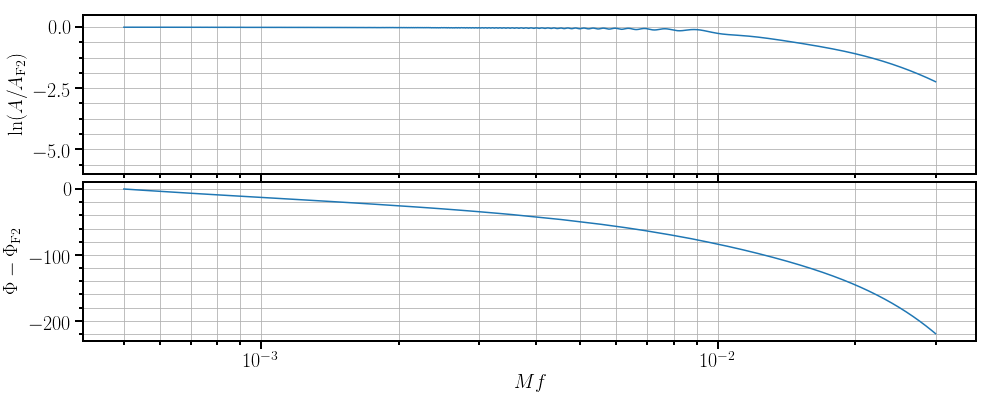

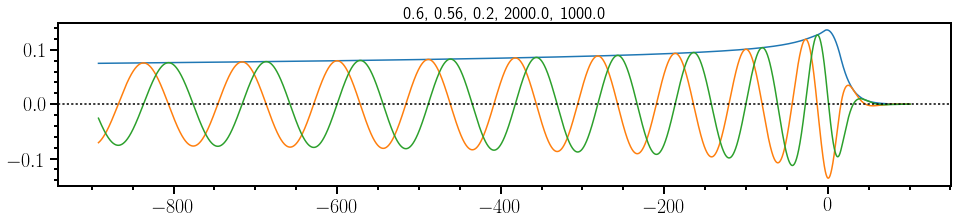

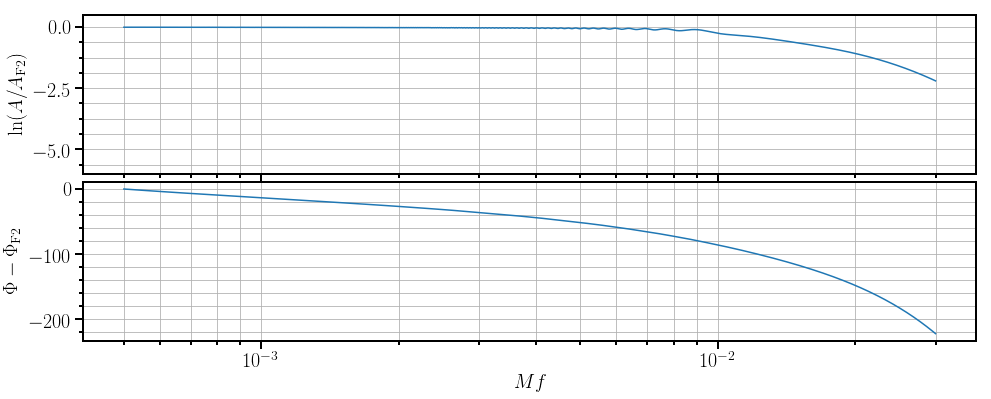

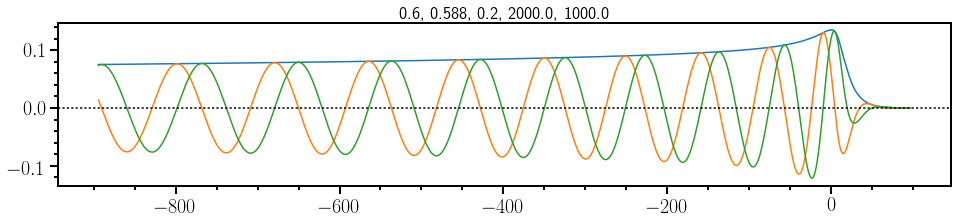

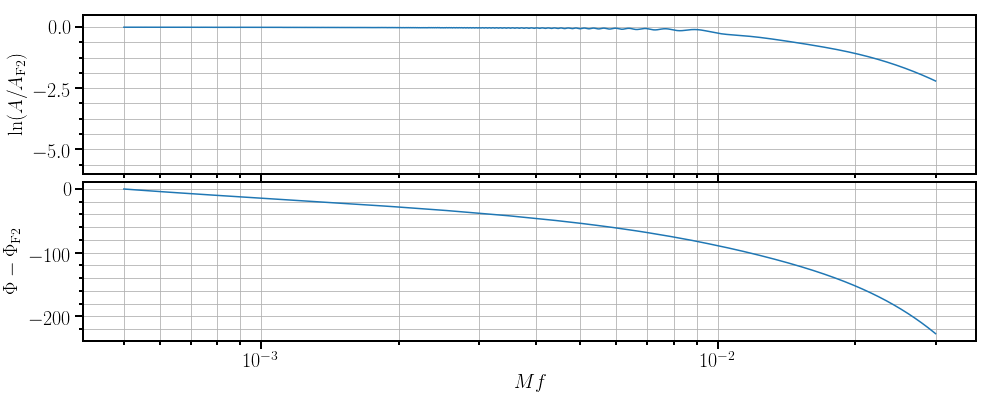

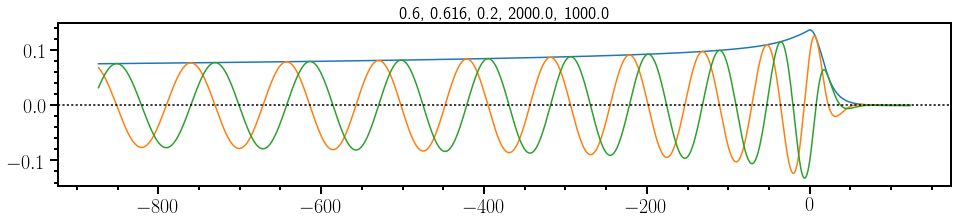

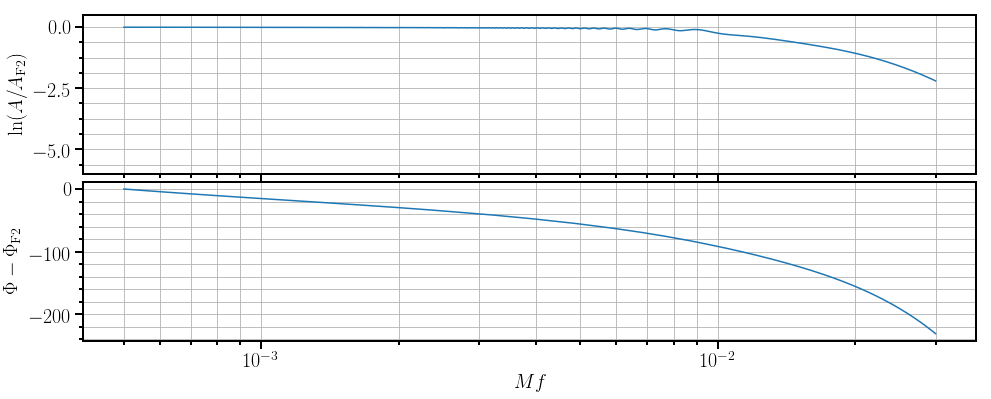

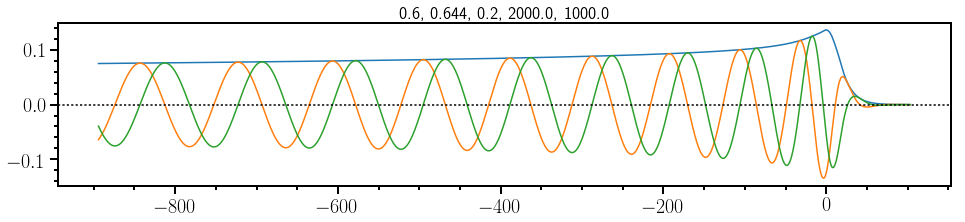

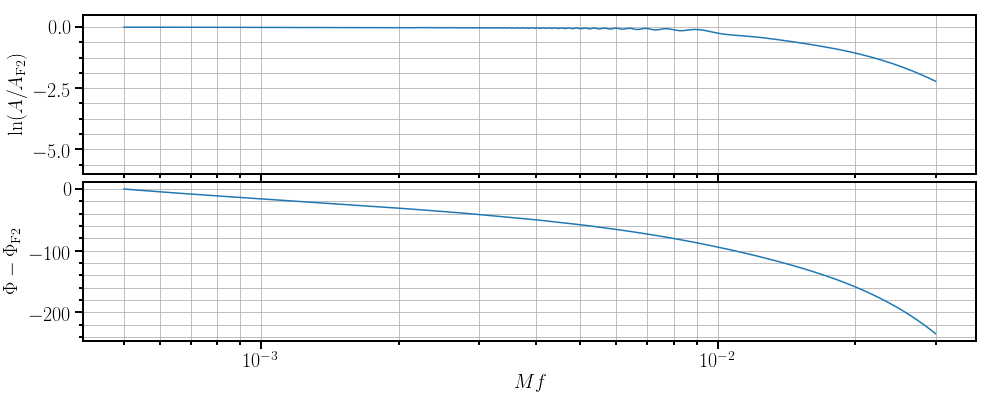

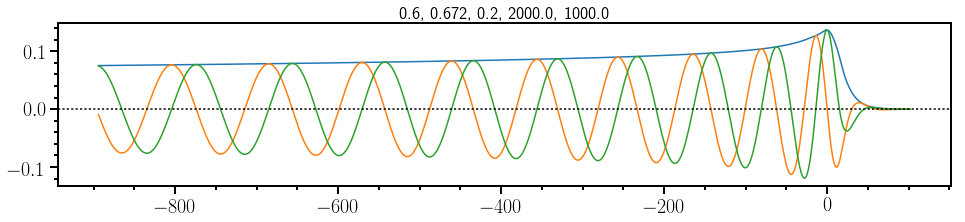

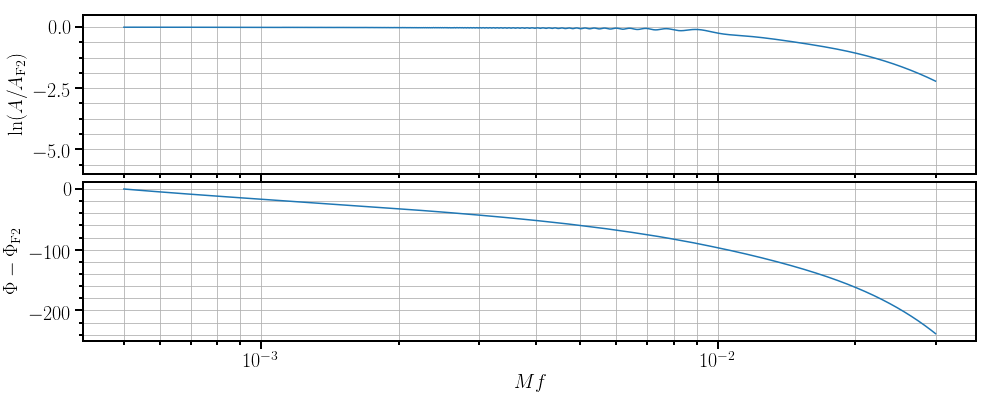

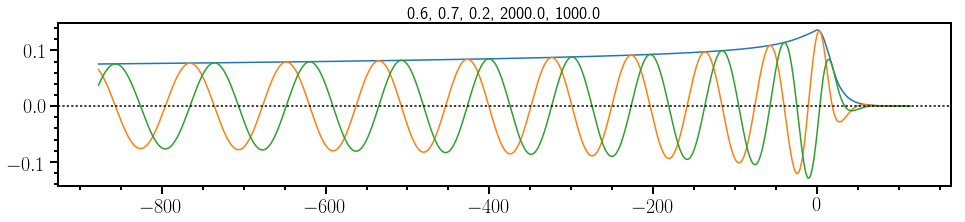

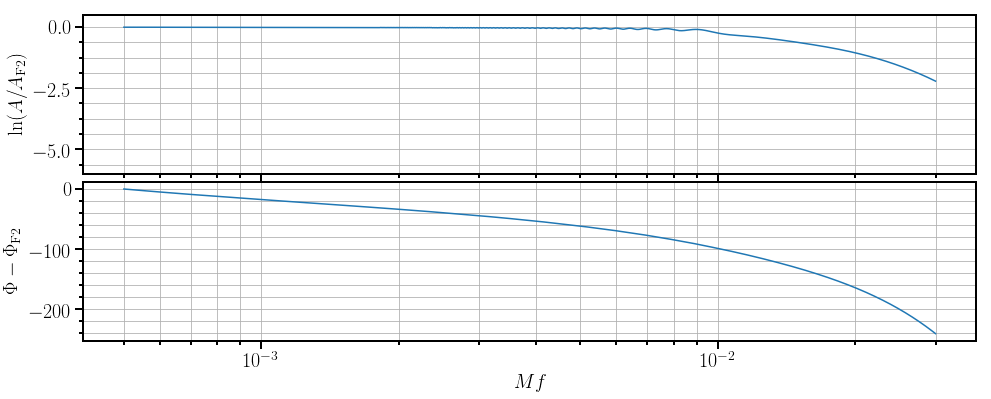

In [11]:
orig_filename = '../../data/teobtest40hz/TEOB_data_1d.hdf5'
h_filename = '../../data/teobtest40hz/h_test_1d.hdf5'
dh_filename = '../../data/teobtest40hz/dh_test_1d.hdf5'

traineob.condition_eob_training_set(
    orig_filename, h_filename, dh_filename,
    delta_t, 
    winon_i, winon_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000,
    win='planck', plots=True, 
    mtot=2.0, distance=1.0)

# condition_eob_training_set_raw(
#     hlist, params, h_filename, dh_filename,
#     delta_t, 
#     winon_i, winon_f, 
#     n_ext,
#     trunc_i, trunc_f, npoints=10000,
#     win='planck', plots=True, 
#     mtot=2.0, distance=1.0)

In [12]:
h_testset_uni = ws.HDF5WaveformSet('../../data/teobtest40hz/h_test_1d.hdf5')
dh_testset_uni = ws.HDF5WaveformSet('../../data/teobtest40hz/dh_test_1d.hdf5')

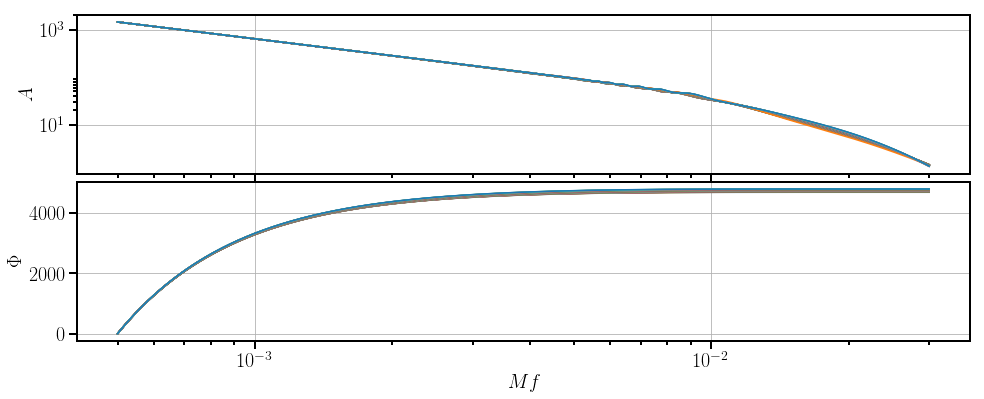

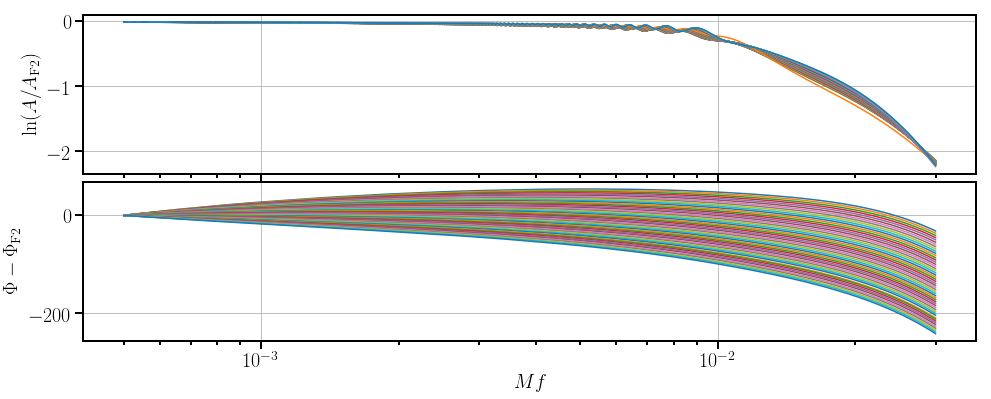

In [13]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_testset_uni[i] for i in range(len(h_testset_uni))])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_testset_uni[i] for i in range(len(dh_testset_uni))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

(-0.013, -0.008)

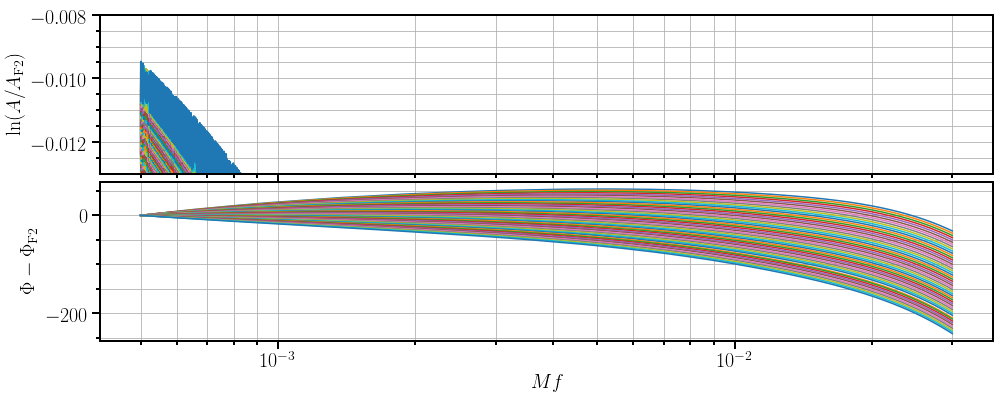

In [14]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_testset_uni[i] for i in range(len(dh_testset_uni))])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_ylim(-0.013, -0.008)

(-0.1, -0.008)

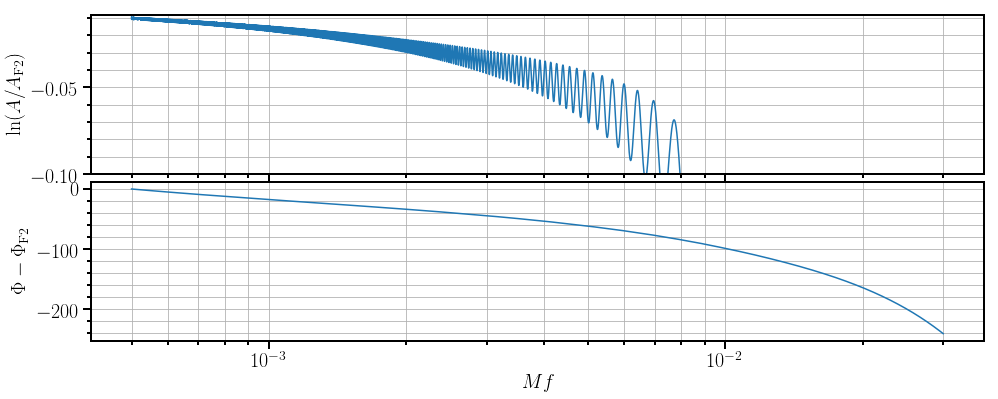

In [159]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_testset_uni[50]])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_ylim(-0.1, -0.008)

In [15]:
# mf = 0.011
# print mf, mf_to_f(mf, 2.)

# spin1z_arr = np.array([dh_testset_uni.get_waveform(i, data='parameters')[1] for i in range(len(dh_testset_uni))])

# ps = []
# amps = []
# for i in range(len(dh_testset_uni)):
#     p = dh_testset_uni.get_waveform(i, data='parameters')[1]
#     h = dh_testset_uni[i]
#     amp = h.interpolate('amp')(mf)
#     ps.append(p)
#     amps.append(amp)
    
# np.array([np.array(ps), np.array(amps)]).T

0.01 1015.12721759
-105.155537291 -28.8813742527


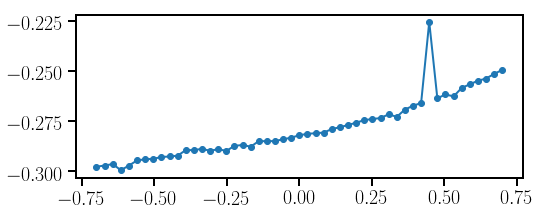

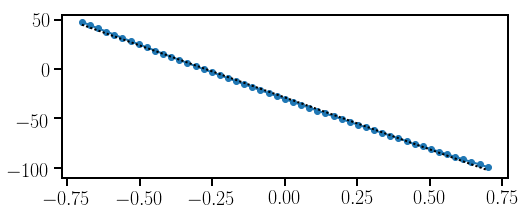

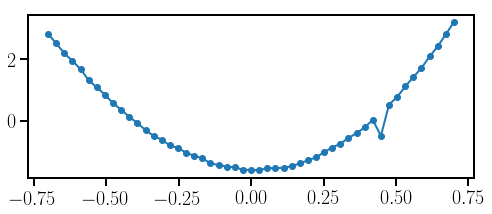

In [162]:
mf = 0.01
print mf, mf_to_f(mf, 2.)

spin1z_arr = np.array([dh_testset_uni.get_waveform(i, data='parameters')[1] for i in range(len(dh_testset_uni))])

ps = []
amps = []
for i in range(len(dh_testset_uni)):
    p = dh_testset_uni.get_waveform(i, data='parameters')[1]
    h = dh_testset_uni[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(dh_testset_uni)):
    p = dh_testset_uni.get_waveform(i, data='parameters')[1]
    h = dh_testset_uni[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
print slope, intercept

x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)

In [21]:
import h5py

def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        params.append(p)
        hlist.append(h)
        
    return np.array(params), hlist

In [23]:
orig_filename = '../../data/teobtest40hz/TEOB_data_1d.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)
print params


        approximant = TEOBv4
        M = 2
        fs = 16384
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.0.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 [[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -6.72000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -6.44000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -6.16000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -5.88000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -5.60000000e-01   2.00000000e-01   2.00000000e+03
    1.00000000e+03]
 [  6.00000000e-01  -5.32000000e-01   2.00000000e-01   2.00000000e+03
    1.00000

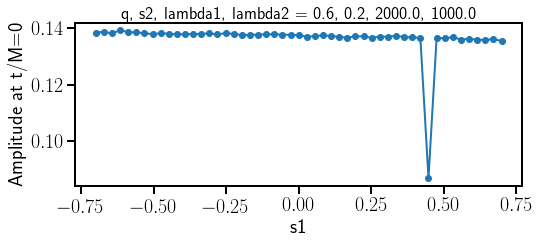

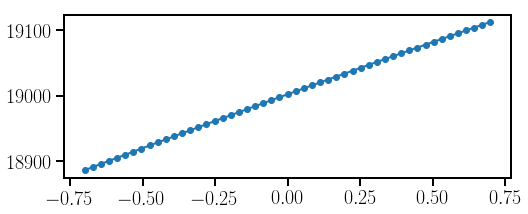

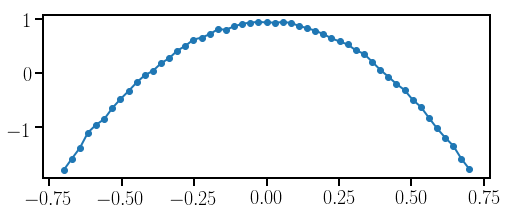

In [40]:
t = 0

ps = []
amps = []
for i in range(len(hlist)):
    p = params[i, 1]
    h = hlist[i]
    amp = h.interpolate('amp', order=2)(t)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)
title = 'q, s2, lambda1, lambda2 = {:.3}, {:.3}, {:.1f}, {:.1f}'.format(params[0, 0], params[0, 2], params[0, 3], params[0, 4])
axes.set_title(title)
axes.set_xlabel('s1')
axes.set_ylabel('Amplitude at t/M=0')

ps = []
phases = []
for i in range(len(hlist)):
    p = params[i, 1]
    h = hlist[i]
    phase = h.interpolate('phase', order=2)(t)
    ps.append(p)
    phases.append(phase)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)




slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
x_fit = np.array(ps)
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)

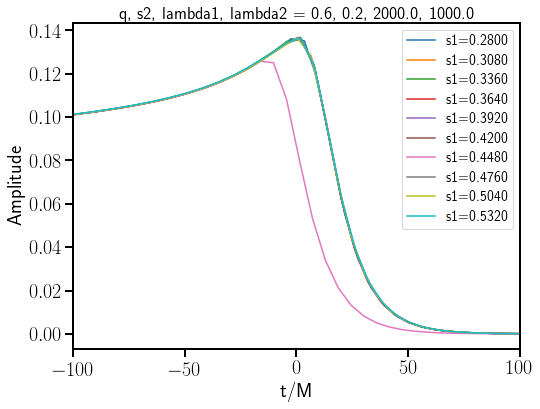

In [36]:
fig, ax = plt.subplots()
for i in range(35, 45):
    h = hlist[i]
    ax.plot(h.x, h.amp, label='s1={:.4f}'.format(params[i, 1]))

ax.set_xlim(-100, 100)
ax.legend()
title = 'q, s2, lambda1, lambda2 = {:.3}, {:.3}, {:.1f}, {:.1f}'.format(params[0, 0], params[0, 2], params[0, 3], params[0, 4])
ax.set_title(title)
ax.set_xlabel('t/M')
ax.set_ylabel('Amplitude')